# ABOUT
__Author__: Pat McCornack

__Purpose__: Evaluate model results. 

In [2]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import rasterio
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Define Filepaths

In [17]:
local_root_dir = r"C:\Users\mcco573\OneDrive - PNNL\Documents\_Projects\BPA Wildfire\Fuel Attributes Model"
pnnl_root_dir = r"\\pnl\projects\BPAWildfire\data\Landfire\fuels_modeling\Fuel Attributes Model"

# Define which data directory to work off of
active_root_dir = pnnl_root_dir

# Define filepaths
paths_dict = {
    'ref_data_dir' : os.path.join(active_root_dir, r"..\LF_raster_data\_tables"),  # used by read_ref_data
    'pred_data_dir' : os.path.join(active_root_dir, r"model_outputs\tabular"),
    'FVT_pred_data_fname' : r'model_results_2024-05-02_09-40-36\Predictions_LF22_FVT_HGBC.csv',
    'FVT_F40_pred_data_fname' : r'model_results_2024-05-07_11-22-57\Predictions_LF22_F40_HGBC.csv',
    'FVC_pred_data_fname' : r'model_results_2024-05-02_15-19-34\Predictions_LF22_FVC_HGBC.csv',
    'FVH_pred_data_fname' : r'model_results_2024-05-02_15-41-04\Predictions_LF22_FVH_HGBC.csv',
    'results_outdir' : os.path.join(active_root_dir, r'model_outputs\tabular'),

    # Rasters
    'LF22_FDST' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FDst_230_bpa.tif"),
    'pred_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_FVT_2024-05-06_12-02-39.tif"),
    'og_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FVT_230_bpa.tif"),
    'pred_F40_with_FVT_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_F40_Pred_with_Pred_FVT_2024-05-14_16-57-02.tif"),
    'og_F40_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_F40_230_bpa.tif"),
    'pred_FVC_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_Pred_FVC_2024-05-15_09-26-36.tif"),
    'og_FVC_raster' : os.path.join(active_root_dir, r"..\LF_raster_data\bpa_service_territory\LC22_FVC_230_bpa.tif"),

    # Outfiles
    'results_outdir' : os.path.join(active_root_dir, r'model_outputs\tabular'),
    'FVC_results_fname' : 'results_LF22_Pred_FVT_2024-05-06_12-02-39.csv',
    'FVT_results_fname' : 'LF22_Pred_FVC_2024-05-15_09-26-36.csv'
}



# __Functions__
----

## __Visualizations__

### __Plot the Class Distribution__
Plots the distribution of the variable of interest. Can be set to display the raw counts for each class or the percentage of the dataste that the class accounts for. 

In [4]:
def plot_distribution(df, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots the distribution of group_var. 'metric' can be set to either 'Count' or 'Percent' to change the display type. 
    The 'sort' argument specifies whether to sort the display in order from most common to least common. 
    """
    # Get count of target class
    df_gp = df.groupby(group_var).count().reset_index()
    df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

    # Get classes proportional representation
    df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
    df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str
    if sort == True: 
        df_gp = df_gp.sort_values(by="Count", ascending=True)

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    hbars = ax.barh(df_gp[group_var],
                df_gp[metric],
                align='center')
    ax.set(title=title,
        xlabel= f'{metric}', 
        ylabel=f'{group_var}')  
    ax.bar_label(hbars, fmt=" %.2f")
    
    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y(), ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Compare the Distribution of the Misclasses vs. Actual__
Plot a graph to see how the distribution of the misclasses compares with the distribution of the true classes. Metric can be set to 'Count' for raw counts or 'Percent'. If metric='Percent', then the 'total' value represents the percent representation of that class in the original dataset (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 7.47% of observations in the true dataset), and the 'Misclass' value is the percent proportion of the misclassification data (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 9.91% of all misclassed observations).

In [5]:
def plot_comparison_distribution(df_dict, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots distributions of the true vs. misclassed datasets.

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # sort values before plotting
    if sort == True:
        df_gp_dict['misclass'] = df_gp_dict['misclass'].sort_values(by=metric)
        df_gp_dict['total'] = df_gp_dict['total'].reindex(df_gp_dict['misclass'].index)

    # Set up to plot side-by-side
    ind = np.arange(len(df_gp_dict['misclass'])) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_bar = ax.barh(ind+width/2, df_gp_dict['total'][metric], width, label='Total')
    misclass_bar = ax.barh(ind-width/2, df_gp_dict['misclass'][metric], width, label='Misclass')

    ax.set_title(title)
    ax.set_xlabel(f'{metric}')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['misclass'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_bar, fmt=" %.2f")
    ax.bar_label(misclass_bar, fmt=" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Assess the Proportion of the Actual Values that were Misclasses__
Create a plot to display the percentage of each class that was misclassified alongside that classes total representation in the dataset. Setting the 'metric' argument will only affect how the total representation is displayed - by 'Count' or 'Percent' - the misclassified proportion will not change. 

In [6]:
# Plots the percent of the total class the misclass count is
def plot_percent_total(df_dict, group_var, sort=True, title=f'Distribution', metric='Count', figsize=(15, 50)):
    """
    Plots the proportion of each class that was misclassified, alongside its total representation in the dataset. 

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # Calculate percent of total 
    total_perc = df_gp_dict['misclass']['Count'] / df_gp_dict['total']['Count'] * 100

    # Sort the data before plotting
    if sort == True:
        total_perc = total_perc.sort_values()
        df_gp_dict['total'] = df_gp_dict['total'].reindex(total_perc.index)

    # Set up to plot side-by-side
    ind = np.arange(len(total_perc)) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_count_bar = ax.barh(ind-width/2, df_gp_dict['total'][metric], width, label=f'Total {metric}')
    total_perc_bar = ax.barh(ind+width/2, total_perc, width, label='Misclass Percent')
  
    ax.set_title(title)
    ax.set_xlabel('Percent')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['total'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_perc_bar, fmt=" %.2f")
    ax.bar_label(total_count_bar, fmt=f" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

## __Data Processing__

### __Create Data Dictionaries to Append Features__
Some features are separate attributes of the LANDFIRE dataset (e.g. BPS Fire Regime) and others are useful for results analysis (e.g. FDst attributes). These can be mapped to points using LANDFIRE CSVs. The below creates dictionaries to perform that mapping. 

This function is called by join_features.

In [7]:
def read_ref_data(ref_data_dir=paths_dict['ref_data_dir']):
    """
    Returns a dictionary of dictionaries of mappings between LANDFIRE raster values and other attributes associated with those values. 
    """
    data_dir = ref_data_dir
    LF22_FVT_fname = "LF22_FVT_230.csv"
    LF22_FVC_fname = "LF22_FVC_230.csv"
    LF22_FVH_fname = "LF22_FVH_230.csv"
    
    # Create empty dictionary
    LF_ref_dicts = {}

    # Join fuel type names from values
    LF22_FVT_df = pd.read_csv(os.path.join(data_dir, LF22_FVT_fname))
    LF_ref_dicts['Original_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
    LF_ref_dicts['Predicted_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
   
    # Join fuel cover names from values
    LF22_FVC_df = pd.read_csv(os.path.join(data_dir, LF22_FVC_fname))
    LF_ref_dicts['Original_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)

    # Join fuel height names from values
    LF22_FVH_df = pd.read_csv(os.path.join(data_dir, LF22_FVH_fname))
    LF_ref_dicts['Original_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)

    return LF_ref_dicts
                         
        

### __Append Features using Data Dictionaries__
Append in selected features using the LANDFIRE data dictionaries.

__Note:__ Items in feature_list must be in the source_layers dictionary. 

In [8]:
def create_features(df, feature_list = ['Original_FVT_NAME', 'Predicted_FVT_NAME'], source_layers = {
        'Original_FVT_NAME' : 'LF22_FVT', 
        'Predicted_FVT_NAME' : 'Predicted_LF22_FVT',
        'Original_FVC_NAME' : 'LF22_FVC', 
        'Predicted_FVC_NAME' : 'Predicted_LF22_FVC',
        'Original_FVH_NAME' : 'LF22_FVH', 
        'Predicted_FVH_NAME' : 'Predicted_LF22_FVH',
    }):
    """
    Returns the sample_points layer with the features in feature_list appended. 

    Items in feature_list must be in the source_layers dictionary.  
    """
    # Get names associated with FVT values
    LF_ref_dicts = read_ref_data()

    # Create the feature
    for feature in feature_list:
        df[feature] = df[source_layers[feature]].map(LF_ref_dicts[feature]).copy()

    # Get Prefix Code -- used to asses ecological similarity
    if feature_list == ['Original_FVT_NAME', 'Predicted_FVT_NAME']:
        df['Original_FVT_Prefix'] = df['Original_FVT_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVT_Prefix'] = df['Predicted_FVT_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVC_NAME', 'Predicted_FVC_NAME']:
        df['Original_FVC_Prefix'] = df['Original_FVC_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVC_Prefix'] = df['Predicted_FVC_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVH_NAME', 'Predicted_FVH_NAME']:
        df['Original_FVH_Prefix'] = df['Original_FVH_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVH_Prefix'] = df['Predicted_FVH_NAME'].str.split(" ",expand=True)[0]

    return df

# __FVT Predictions Evaluation -- Sample Points__

-----


In [28]:
# Read in predictions and append features
pred_fpath = os.path.join(paths_dict['pred_data_dir'], paths_dict['FVT_pred_data_fname'])
predictions = pd.read_csv(pred_fpath)
create_features(predictions)
predictions.head()

Unnamed: 0  LF22_FVT  LF20_FVT  LF16_FVT  LF16_EVT  LF14_EVT  LF22_FDST  \
0       82871      2032      2032      2032      7032      3028        511   
1      176250      2050      2050      2195      7195      3050        133   
2      100965      2169      2106      2106      7106      3220        122   
3       90683      2055      2046      2046      7046      3046        512   
4       51596      2043      2043      2197      7197      3043        123   

   ZONE   BPS  ASPECT  ...  FDST_SEV           FDST_TSD   EVT_PHYS  \
0     7   798     309  ...       Low           One Year    Conifer   
1    19   464      33  ...      High   Six to Ten Years  Grassland   
2    10   449     102  ...  Moderate  Two to Five Years  Shrubland   
3    21   689      39  ...       Low  Two to Five Years    Conifer   
4     3  2722      83  ...  Moderate   Six to Ten Years    Conifer   

                             EVT_GP_N               EVT_CLASS  \
0         Red Fir Forest and Woodland        Open tree canopy   
1  Transitional Herbaceous Vegetation  Herbaceous - grassland   
2                 Deciduous Shrubland               Shrubland   
3     Subalpine Woodland and Parkland        Open tree canopy   
4      Transitional Forest Vegetation        Open tree canopy   

   Predicted_LF22_FVT                                  Original_FVT_NAME  \
0                2032         Tr Mediterranean California Red Fir Forest   
1                2050            Tr Rocky Mountain Lodgepole Pine Forest   
2                2106  Sh Northern Rocky Mountain Subalpine Deciduous...   
3                2046  Tr Rocky Mountain Subalpine Dry-Mesic Spruce-F...   
4                2043  Tr Mediterranean California Mixed Evergreen Fo...   

                                  Predicted_FVT_NAME  Original_FVT_Prefix  \
0         Tr Mediterranean California Red Fir Forest                   Tr   
1            Tr Rocky Mountain Lodgepole Pine Forest                   Tr   
2  Sh Northern Rocky Mountain Montane-Foothill De...                   Sh   
3  Tr Northern Rocky Mountain Subalpine Woodland ...                   Tr   
4  Tr Mediterranean California Mixed Evergreen Fo...                   Tr   

   Predicted_FVT_Prefix  
0                    Tr  
1                    Tr  
2                    Sh  
3                    Tr  
4                    Tr  

[5 rows x 34 columns]

## __Check Overall Accuracy__
How many observations were assigned the correct FVT value?

In [29]:
# Subset to observations where Predicted == Actual
match = predictions.loc[predictions['LF22_FVT'] == predictions['Predicted_LF22_FVT']]

# Calculate the percent of the total dataset that was correctly classified
match_perc = len(match) / len(predictions) * 100

print(f'Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Mismatch Count: 11619 of 38537
Matching Percent: 69.85%


## __Check Prefix Matches__
The prefix of each FVT indicates the lifeform of that FVT (e.g. an FVT with prefix 'Tr' indicates that the lifeform is Tree). These prefixes provide a coarse measure of ecological similarity - i.e. even if an observation's FVT was misclassified, was the correct lifeform identified?  

In [30]:
# Subset to observations where Predicted Prefix == Actual Prefix
match = predictions.loc[predictions['Original_FVT_Prefix'] == predictions['Predicted_FVT_Prefix']]

# Calculate the percent of the total dataset with the correctly identified prefix
match_perc = len(match) / len(predictions) * 100
print(f'Prefix Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Prefix Mismatch Count: 530 of 38537
Matching Percent: 98.62%


## __Check Misclass Distribution - Mismatched FVTs__
Assess which FVTs were most commonly misclassified as well as each classes total representation in the dataset.

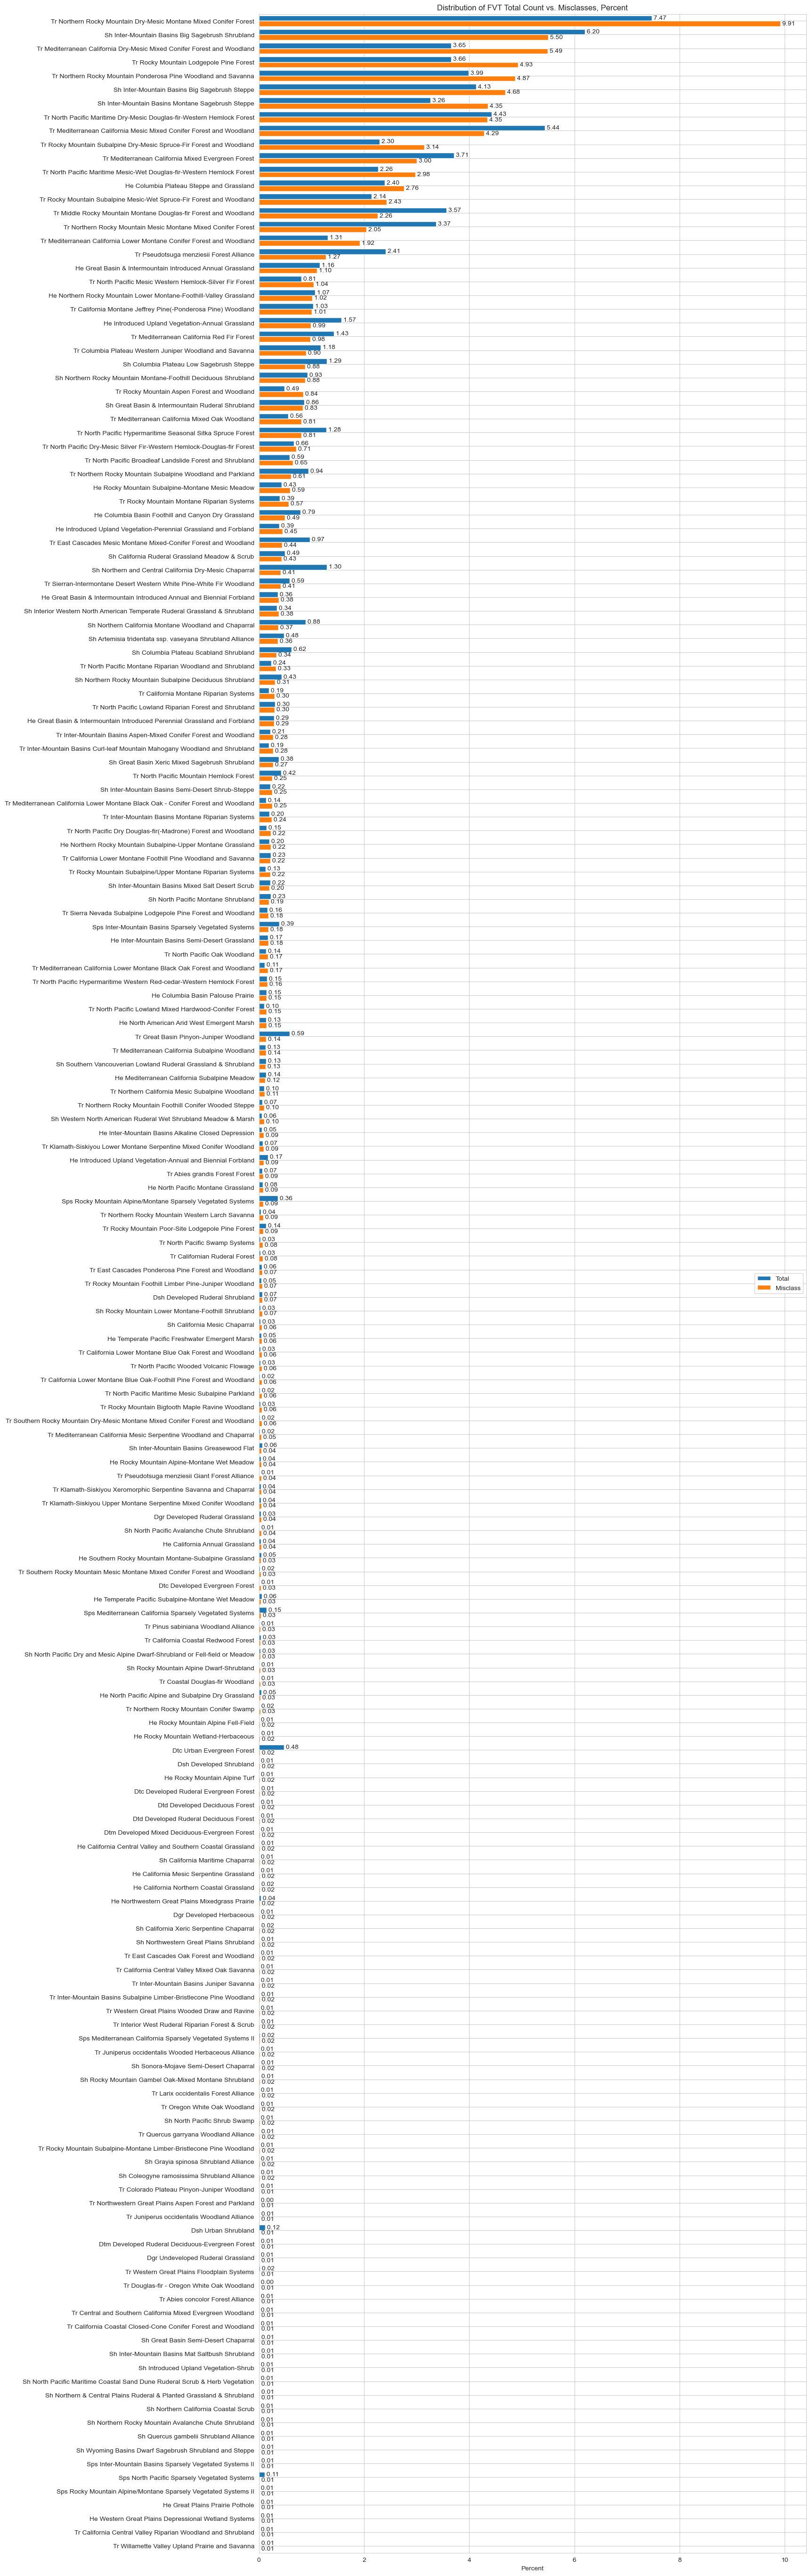

In [31]:
# Subset to misclassified observations
misclass = predictions.loc[~(predictions['LF22_FVT'] == predictions['Predicted_LF22_FVT'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = predictions.loc[predictions['LF22_FVT'].isin(misclass['LF22_FVT'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = f'Distribution of FVT Total Count vs. Misclasses, {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original_FVT_NAME', metric=metric, title=title, figsize=(15, 70))


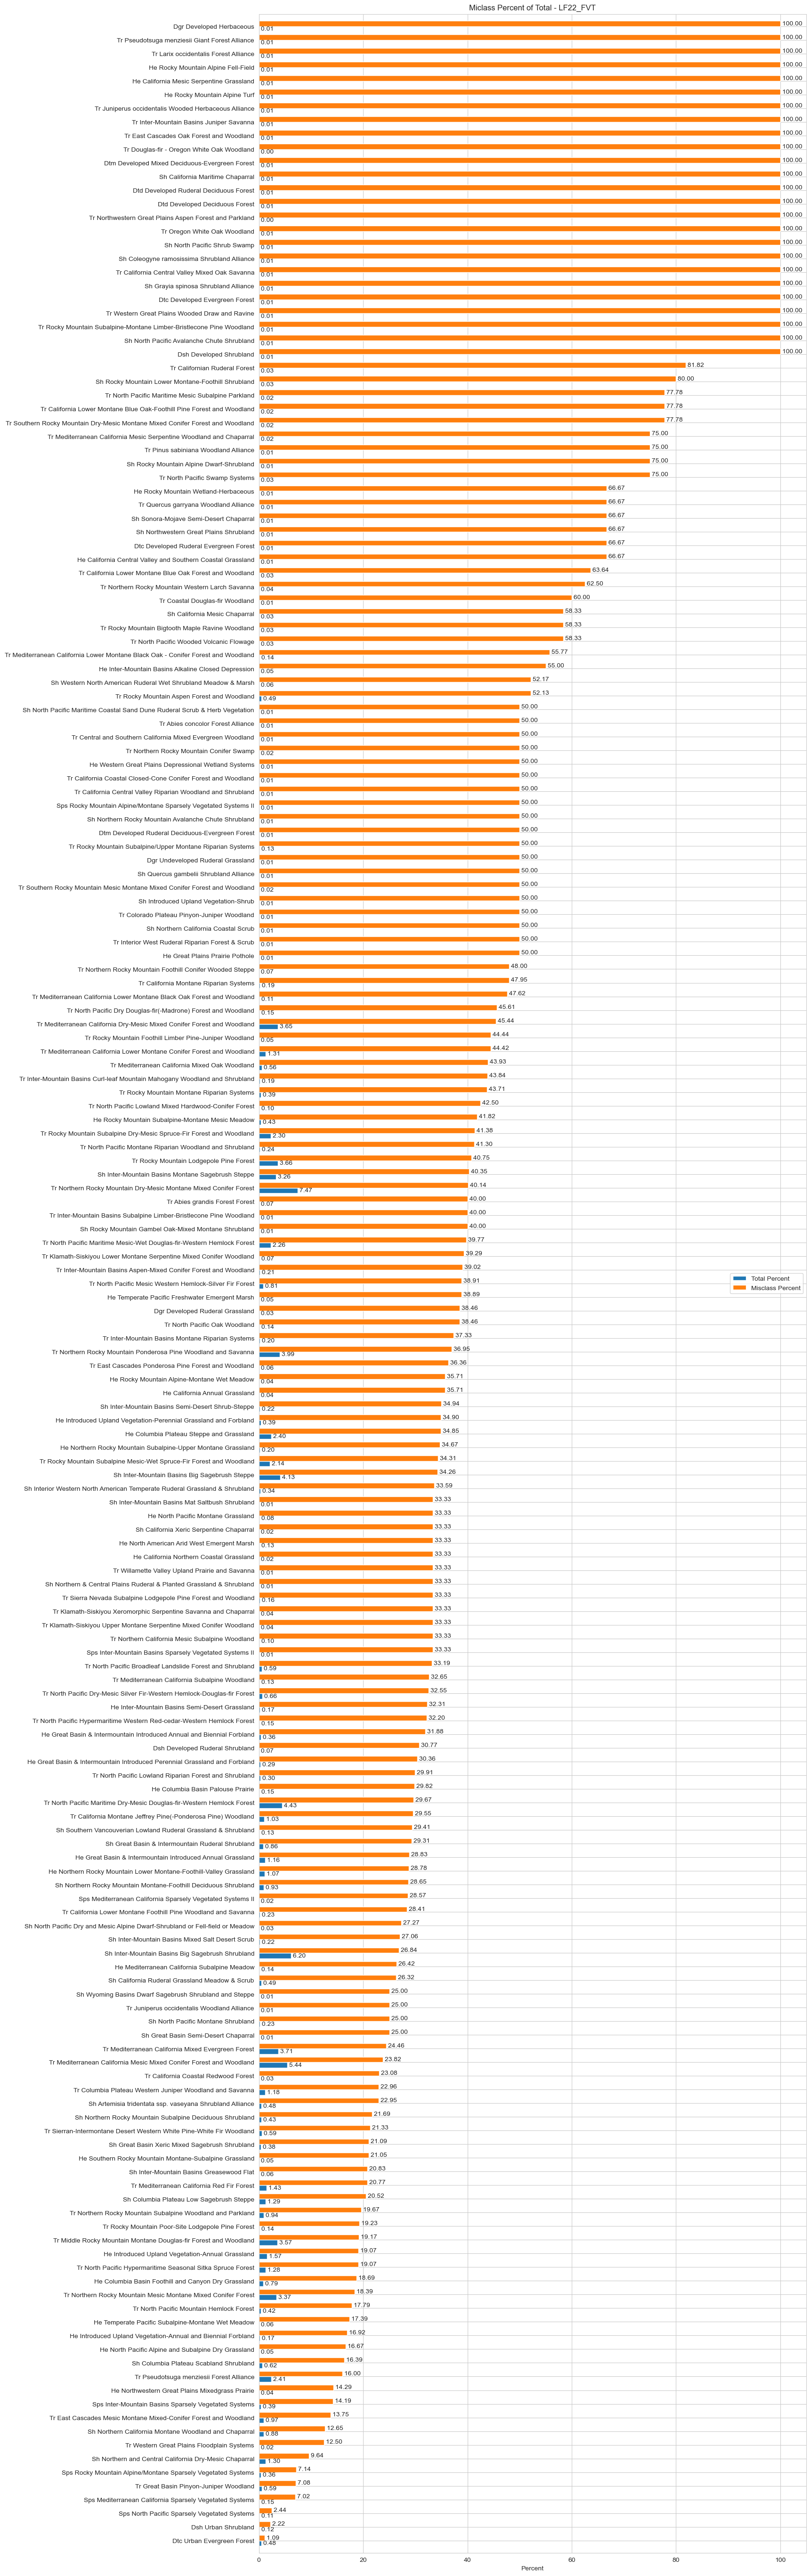

In [32]:
# Subset to misclassified observations
misclass = predictions.loc[~(predictions['LF22_FVT'] == predictions['Predicted_LF22_FVT'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = predictions.loc[predictions['LF22_FVT'].isin(misclass['LF22_FVT'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22_FVT"
plot_percent_total(df_dict=df_dict, group_var='Original_FVT_NAME', metric=metric, title=title, figsize=(15, 70))

## __Check Misclass Distribution - Mismatched Prefixes__
Which FVT "lifeforms" are most commonly misclassified? (e.g. He = Herb, Tr = Tree)

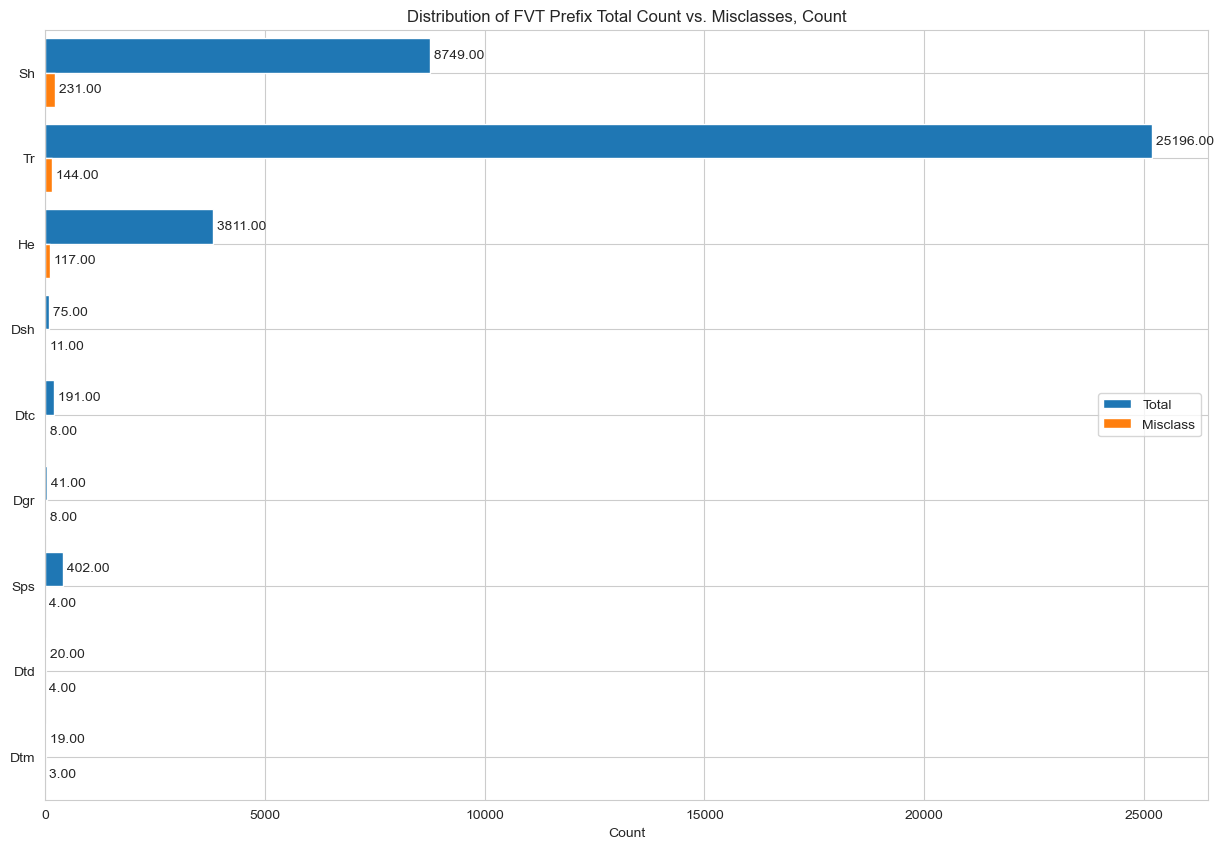

In [33]:
# Subset to misclassified observations
misclass = predictions.loc[~(predictions['Original_FVT_Prefix'] == predictions['Predicted_FVT_Prefix'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = predictions.loc[predictions['Original_FVT_Prefix'].isin(misclass['Original_FVT_Prefix'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of FVT Prefix Total Count vs. Misclasses, {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original_FVT_Prefix', metric=metric, title=title, figsize=(15, 10))


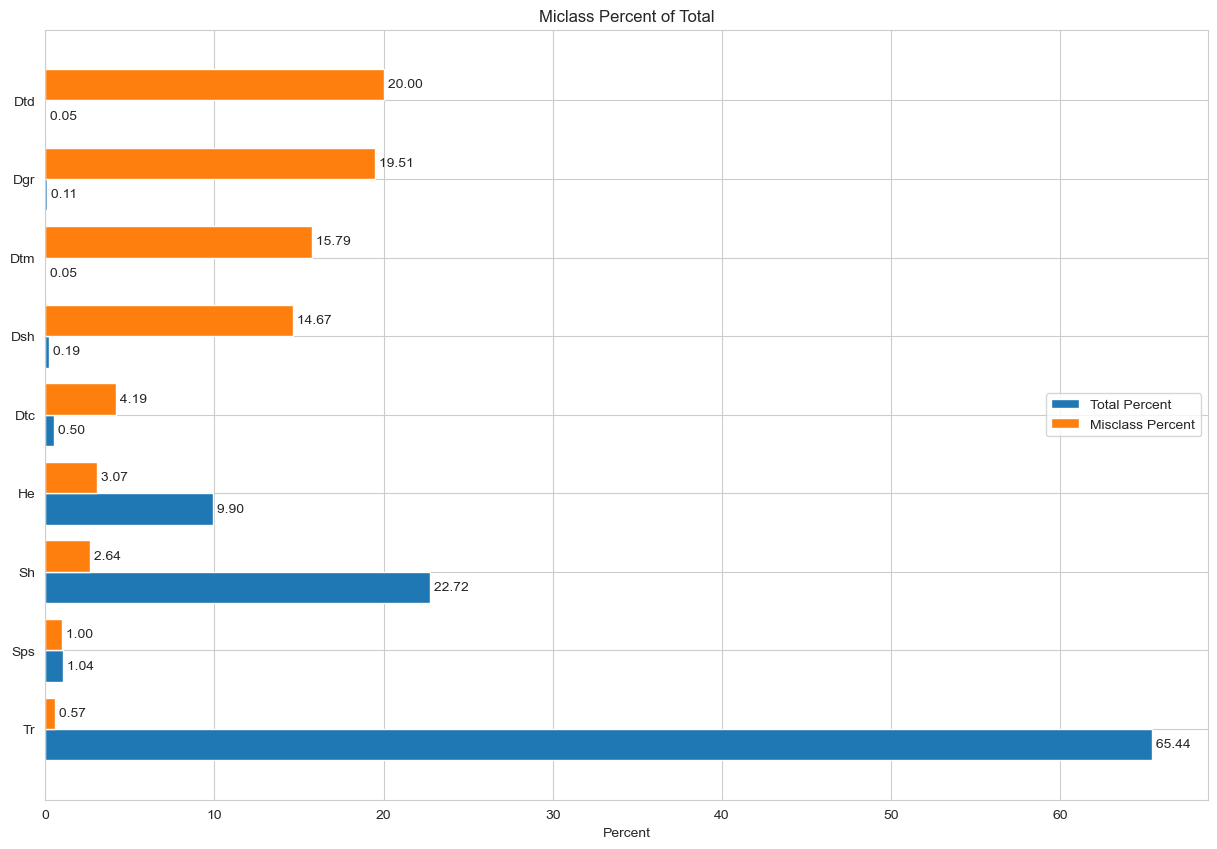

In [34]:
# Subset to misclassified observations
misclass = predictions.loc[~(predictions['Original_FVT_Prefix'] == predictions['Predicted_FVT_Prefix'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = predictions.loc[predictions['Original_FVT_Prefix'].isin(misclass['Original_FVT_Prefix'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}
# Plot the data
metric='Percent'
title = "Miclass Percent of Total"
plot_percent_total(df_dict=df_dict, group_var='Original_FVT_Prefix', metric=metric, title=title, figsize=(15, 10))

## __Misclass Distribution - FVT = 2045__
Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest (FVT=2045) is the most misclassified - look at what it's commonly being misclassified to. 

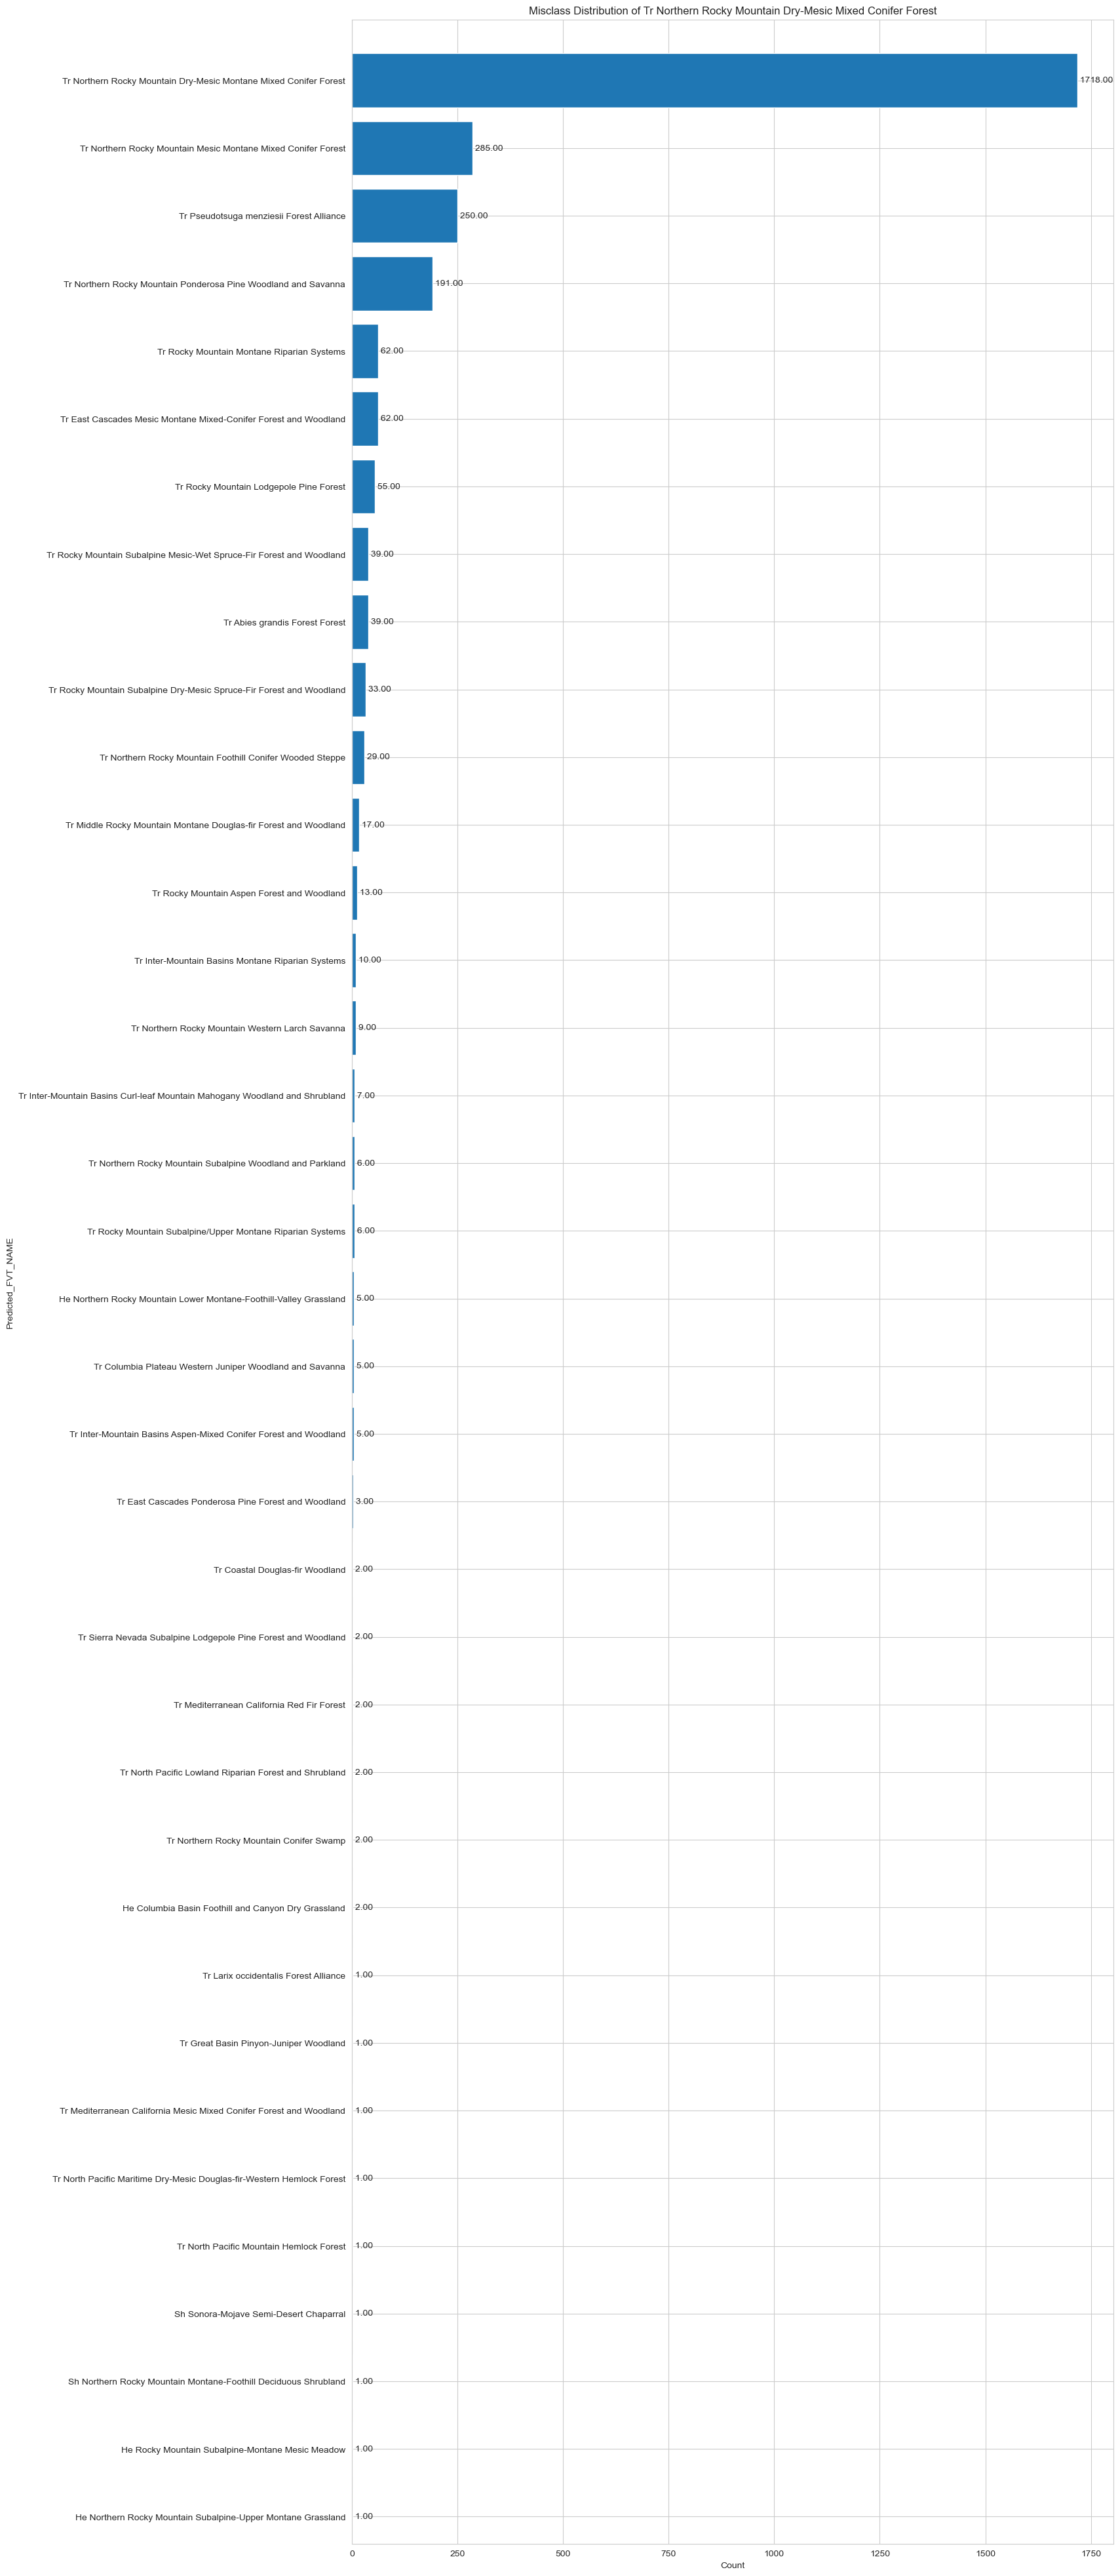

In [35]:
# Subset to observations of a single class
FVT_2045 = predictions.loc[predictions['LF22_FVT']==2045]
plot_distribution(df=FVT_2045, group_var="Predicted_FVT_NAME", title="Misclass Distribution of Tr Northern Rocky Mountain Dry-Mesic Mixed Conifer Forest")

## __Misclassifications based on FDST__

Are there certain FDST categories that are more commonly misclassified?  

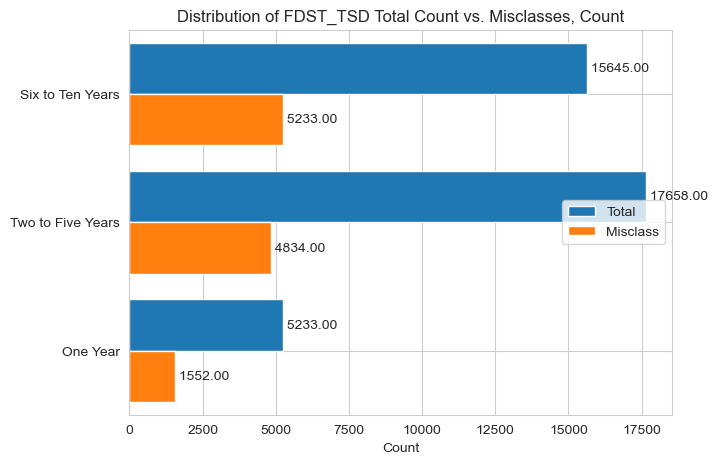

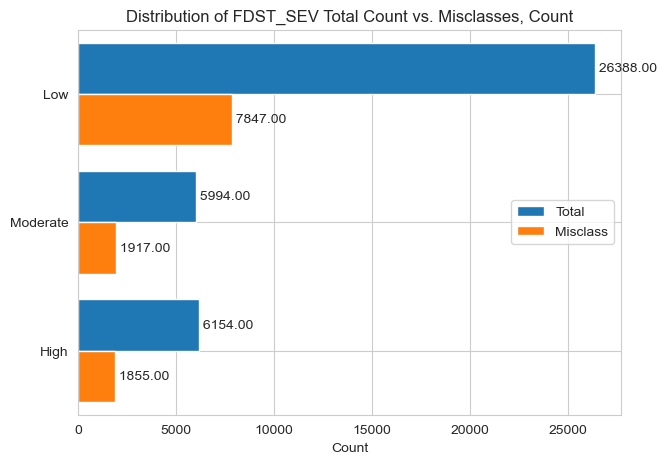

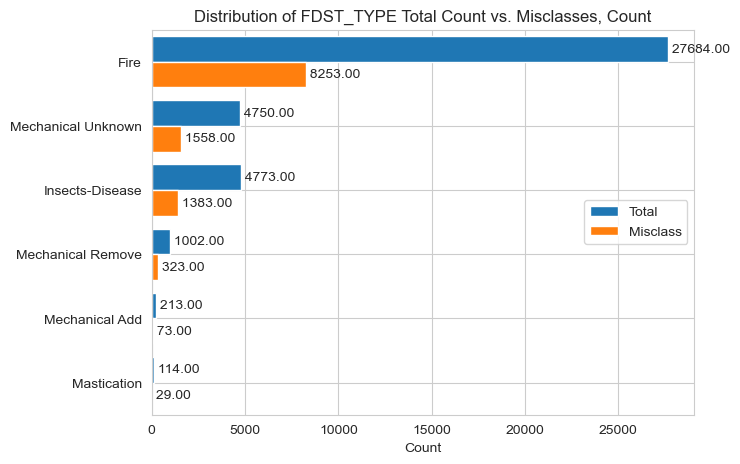

In [36]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVT'] == predictions['Predicted_LF22_FVT'])]

# Drop FDST_TYPE groups not in misclass
mis_type_gps = misclass['FDST_TYPE'].unique()
preds_dropped = predictions.loc[predictions['FDST_TYPE'].isin(mis_type_gps)]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Count'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_comparison_distribution(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))

## __Misclassifications based on ZONE__
Are there specific LANDFIRE zones that the model is struggling with? 

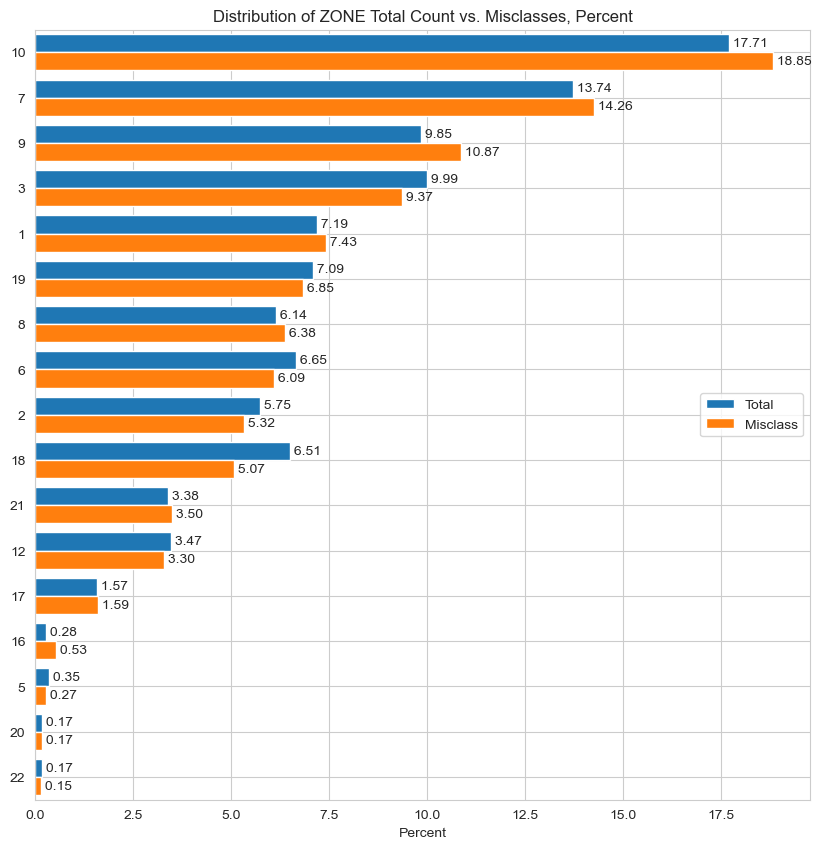

In [37]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVT'] == predictions['Predicted_LF22_FVT'])]

# Define what plots to generate
group_vars = ['ZONE']

# Generate plots
metric = 'Percent'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_comparison_distribution(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(10, 10))

## __Pyrologic Similarity__
Calculate FVT accuracy based on whether the F40 classification is correct - i.e. if the FVT classification does not match the LANDFIRE classification, but the F40 prediction based on that classification is correct, count that observation as having the FVT correctly classified.

### Read in and prepare the data

In [38]:
# Read in data
pred_fpath = os.path.join(paths_dict['pred_data_dir'], paths_dict['FVT_F40_pred_data_fname'])
predictions = pd.read_csv(pred_fpath)

# Subset to features of interest
predictions = predictions[['Original_LF22_FVT', 'LF22_FVT', 'LF22_F40', 'PRED_LF22_F40', 'LF22_FDST']].rename(columns={'LF22_FVT':'PRED_LF22_FVT',
                                                                                                       'Original_LF22_FVT':'LF22_FVT'})

# Filter out undisturbed observations  -  may be unnecessary if sample points are generated from undisturbe areas
predictions = predictions.loc[predictions['LF22_FDST'] != 0]

# Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
predictions = predictions.loc[~predictions['LF22_FVT'].isin(fvt_filter)]

# Subset to features of interest
predictions = predictions[['LF22_FVT', 'PRED_LF22_FVT', 'LF22_F40', 'PRED_LF22_F40']]
print(predictions.shape)
predictions.head()

(161723, 4)


LF22_FVT  PRED_LF22_FVT  LF22_F40  PRED_LF22_F40
0      2126           2126       122            122
1      2126           2126       122            122
2      2126           2126       122            122
3      2146           2146       102            102
4      2126           2079       122            141

In [40]:
# Create features based on whether predictions were accurate
predictions['FVT_Correct'] = predictions['LF22_FVT'] == predictions['PRED_LF22_FVT']
predictions['F40_Correct'] = predictions['LF22_F40'] == predictions['PRED_LF22_F40']
predictions.head()

LF22_FVT  PRED_LF22_FVT  LF22_F40  PRED_LF22_F40  FVT_Correct  F40_Correct
0      2126           2126       122            122         True         True
1      2126           2126       122            122         True         True
2      2126           2126       122            122         True         True
3      2146           2146       102            102         True         True
4      2126           2079       122            141        False        False

### Calculate adjusted FVT accuracy
The adjusted FVT accuracy considers the FVT to be correct if: 
1. The FVT was correctly classified, or
2. The FVT was incorrectly classified, but the F40 was correctly classified

The ultimate goal of this process is to use the FVT raster as a predictor in the F40 model. Therefore, if the FVT was incorrectly classified but the F40 was correctly classified then we consider the FVT to be 'pyrologically similar' and correct for our purposes. 

In [41]:
# What is the overall accuracy of the FVT model considering 'pyrologic similarity'? 
FVT_corr_cnt = predictions.loc[predictions['FVT_Correct'] == True].shape[0]
FVT_corr_perc = round(FVT_corr_cnt / predictions.shape[0] * 100, 2)

FVT_incorr_F40_corr_cnt = predictions.loc[(predictions['FVT_Correct'] ==  False) & (predictions['F40_Correct']) == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / predictions.shape[0] * 100, 2)

FVT_acc_adj_cnt = FVT_corr_cnt + FVT_incorr_F40_corr_cnt
FVT_acc_adj_perc = round(FVT_acc_adj_cnt / predictions.shape[0] * 100, 2)

print(f"Overall FVT Accuracy: {FVT_corr_perc}% ({FVT_corr_cnt} out of {predictions.shape[0]})")
print(f"Frequency of incorrect FVTs with correct F40s: {FVT_incorr_F40_corr_perc}% ({FVT_incorr_F40_corr_cnt} out of {predictions.shape[0]})")
print(f"Adjusted FVT Accuracy: {FVT_acc_adj_perc}% ({FVT_acc_adj_cnt} out of {predictions.shape[0]})")


Overall FVT Accuracy: 89.41% (144591 out of 161723)
Frequency of incorrect FVTs with correct F40s: 3.03% (4901 out of 161723)
Adjusted FVT Accuracy: 92.44% (149492 out of 161723)


### F40 Misclassification Differences
For cases where FVT is incorrect and F40 is incorrect, what is the difference between the acutal and predicted F40? 

F40 classes with similar values can generally be considered to have similar fuels characteristics, so a difference of 1 would likely have little impact on the fire behavior modeling. Note that differences in multiples of 20 indicate that the fuels "parent class" was misclassified due to how the data is structured (e.g. a difference of 20 may indicate that a 'Grass' was classified as a 'Grass-Shrub') - hence the clustered nature of the graph. 

C:\Users\mcco573\AppData\Local\Temp\ipykernel_21444\3037083262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F40_diff'] = df['LF22_F40'] - df['PRED_LF22_F40']


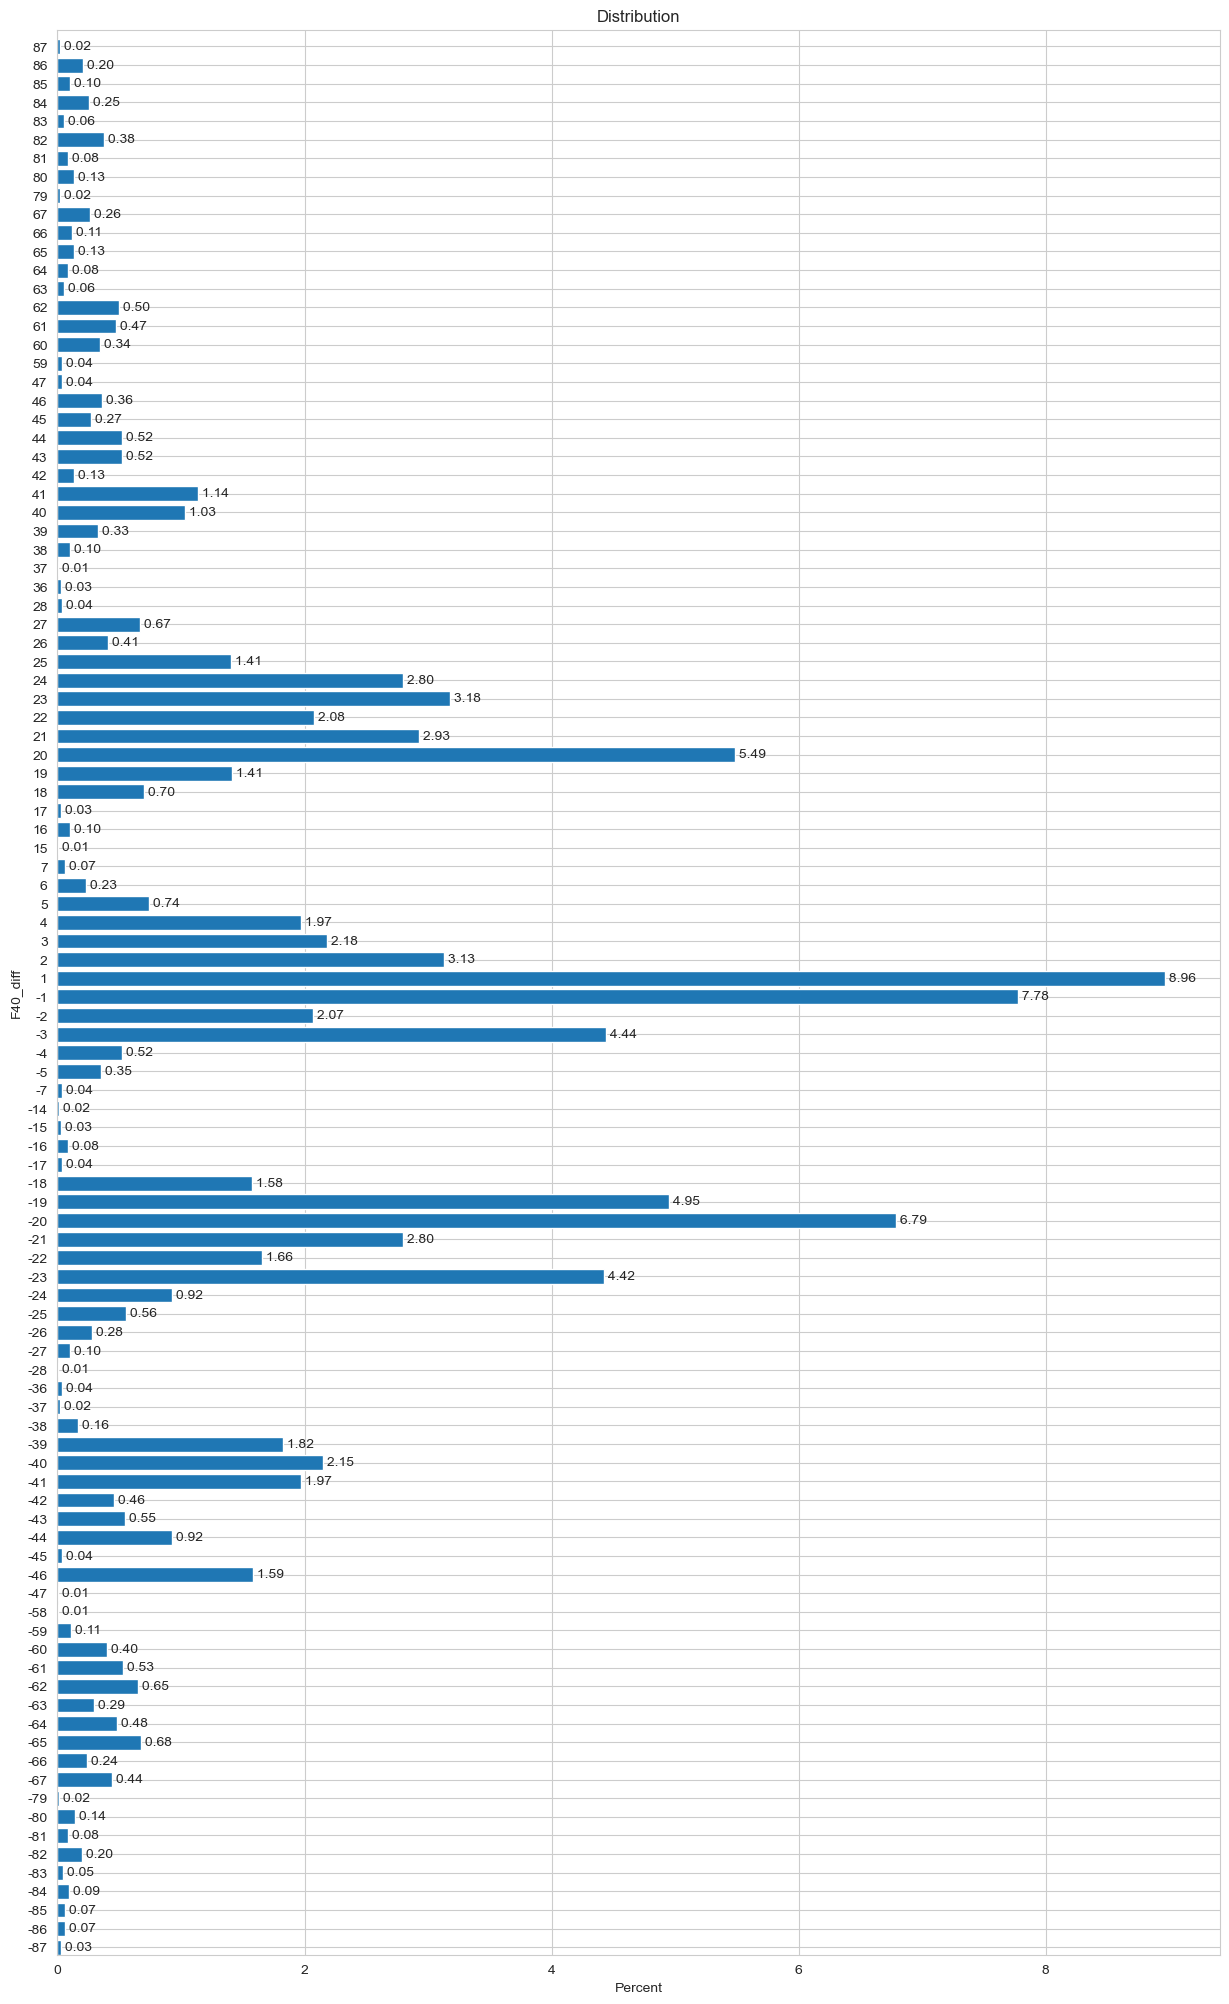

In [42]:
df = predictions.loc[(predictions['FVT_Correct'] == False) & (predictions['F40_Correct'] == False)]
df['F40_diff'] = df['LF22_F40'] - df['PRED_LF22_F40']

plot_distribution(df, group_var='F40_diff', metric='Percent', sort=False, figsize=(15, 25))

### Further break down the results
Further statistics to explore how the predicted FVT values influence the F40 classification.

In [43]:
total_cnt = len(predictions)

# Get overall F40 accuracy
F40_correct_cnt = predictions['F40_Correct'].sum()
F40_overall_acc = round(F40_correct_cnt / total_cnt * 100, 2)

print(f"The overall F40 accuracy is: {F40_overall_acc}% ({F40_correct_cnt} out of {total_cnt})")

# Get overall FVT accuracy
FVT_correct_cnt = predictions['FVT_Correct'].sum()
FVT_overall_acc = round(FVT_correct_cnt / total_cnt * 100, 2)

print(f"The overall FVT accuracy is: {FVT_overall_acc}% ({FVT_correct_cnt} out of {total_cnt})")


The overall F40 accuracy is: 76.01% (122924 out of 161723)
The overall FVT accuracy is: 89.41% (144591 out of 161723)


In [44]:
# How did the F40 model perform with correct FVT classifications? 
FVT_corr_F40_incorr_cnt = predictions.loc[(predictions['FVT_Correct'] == True) & (predictions['F40_Correct'] == False)].shape[0]
FVT_corr_F40_incorr_perc = round(FVT_corr_F40_incorr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_incorr_perc}% of observations had correct FVTs and incorrect F40s ({FVT_corr_F40_incorr_cnt} out of {total_cnt})")

FVT_corr_F40_corr_cnt = predictions.loc[(predictions['FVT_Correct'] == True) & (predictions['F40_Correct'] == True)].shape[0]
FVT_corr_F40_corr_perc = round(FVT_corr_F40_corr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_corr_perc}% of observations had correct FVTs and correct F40s ({FVT_corr_F40_corr_cnt} out of {total_cnt})")


16.43% of observations had correct FVTs and incorrect F40s (26568 out of 161723)
72.98% of observations had correct FVTs and correct F40s (118023 out of 161723)


In [45]:
# How did the model perform with incorrect FVT classifications? 
FVT_incorr = predictions.loc[predictions['FVT_Correct'] == False]
FVT_incorr_total = FVT_incorr.shape[0]

FVT_incorr_F40_corr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / FVT_incorr_total * 100, 2)

FVT_incorr_F40_incorr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == False].shape[0]
FVT_incorr_F40_incorr_perc = round(FVT_incorr_F40_incorr_cnt / FVT_incorr_total * 100, 2)

print(f"Of observations where FVT was misclassed ({FVT_incorr_total}): ")
print(f"{FVT_incorr_F40_corr_perc}% of observations had correct F40 classifications ({FVT_incorr_F40_corr_cnt} of {FVT_incorr_total})")
print(f"{FVT_incorr_F40_incorr_perc}% of observations had incorrect F40 classifications ({FVT_incorr_F40_incorr_cnt} of {FVT_incorr_total})")

Of observations where FVT was misclassed (17132): 
28.61% of observations had correct F40 classifications (4901 of 17132)
71.39% of observations had incorrect F40 classifications (12231 of 17132)


# __FVT Predictions Evaluation -- Raster__ 

## __Summary Statistics__ 

In [28]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_FVT_raster'],
    "Original" : paths_dict['og_FVT_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Truncate the LANDFIRE FBFM40 data to match length of Predictions
## This handles an issue where the predicted raster is one column short of the original 
print(f'Original Dimensions: {data_dict['Original'].shape}')
print(f'Predicted Dimensions: {data_dict['Predictions'].shape}')
data_dict['Original'] = data_dict['Original'][0:len(data_dict['Predictions'])]  # Subset original to size of predictions
data_dict['LF22_FDST'] = data_dict['LF22_FDST'][0:len(data_dict['Predictions'])]  # Subset original to size of predictions

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)
df.head()


Original Dimensions: (1595470745,)
Predicted Dimensions: (1595470745,)


Predictions  Original  LF22_FDST
0        32767     32767      -9999
1        32767     32767      -9999
2        32767     32767      -9999
3        32767     32767      -9999
4        32767     32767      -9999

In [29]:
# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]
print(f"After removing null points: {df.shape[0]}")

# Filter out points that weren't disturbed
df = df.loc[~(df['LF22_FDST'] == 0)]
print(f"After removing undisturbed points: {df.shape[0]}")

# Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
df = df.loc[~df['Original'].isin(fvt_filter)]


After removing null points: 1094586641
After removing undisturbed points: 145899760


In [30]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro')
}
results = pd.DataFrame([results_dict])
print(results)

c:\ProgramData\miniconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   accuracy    recall  precision
0   0.88337  0.667231   0.563552


c:\ProgramData\miniconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Save out results
results.to_csv(os.path.join(paths_dict['results_outdir'], paths_dict['FVT_results_out_fname']))

accuracy    recall  precision
0   0.88337  0.667231   0.563552

## __Visualizations - Raster__

In [ ]:
# Join the names of FVT classes to dataset
source_layers = {
        'Original_FVT_NAME' : 'Original', 
        'Predicted_FVT_NAME' : 'Predictions'
    }
df = create_features(df, feature_list = ['Original_FVT_NAME', 'Predicted_FVT_NAME'], source_layers=source_layers)

In [45]:

# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Count'
title = f'Distribution of FVT Total Count vs. Misclasses  - Raster - {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original_FVT_NAME', metric=metric, title=title, figsize=(15, 70))


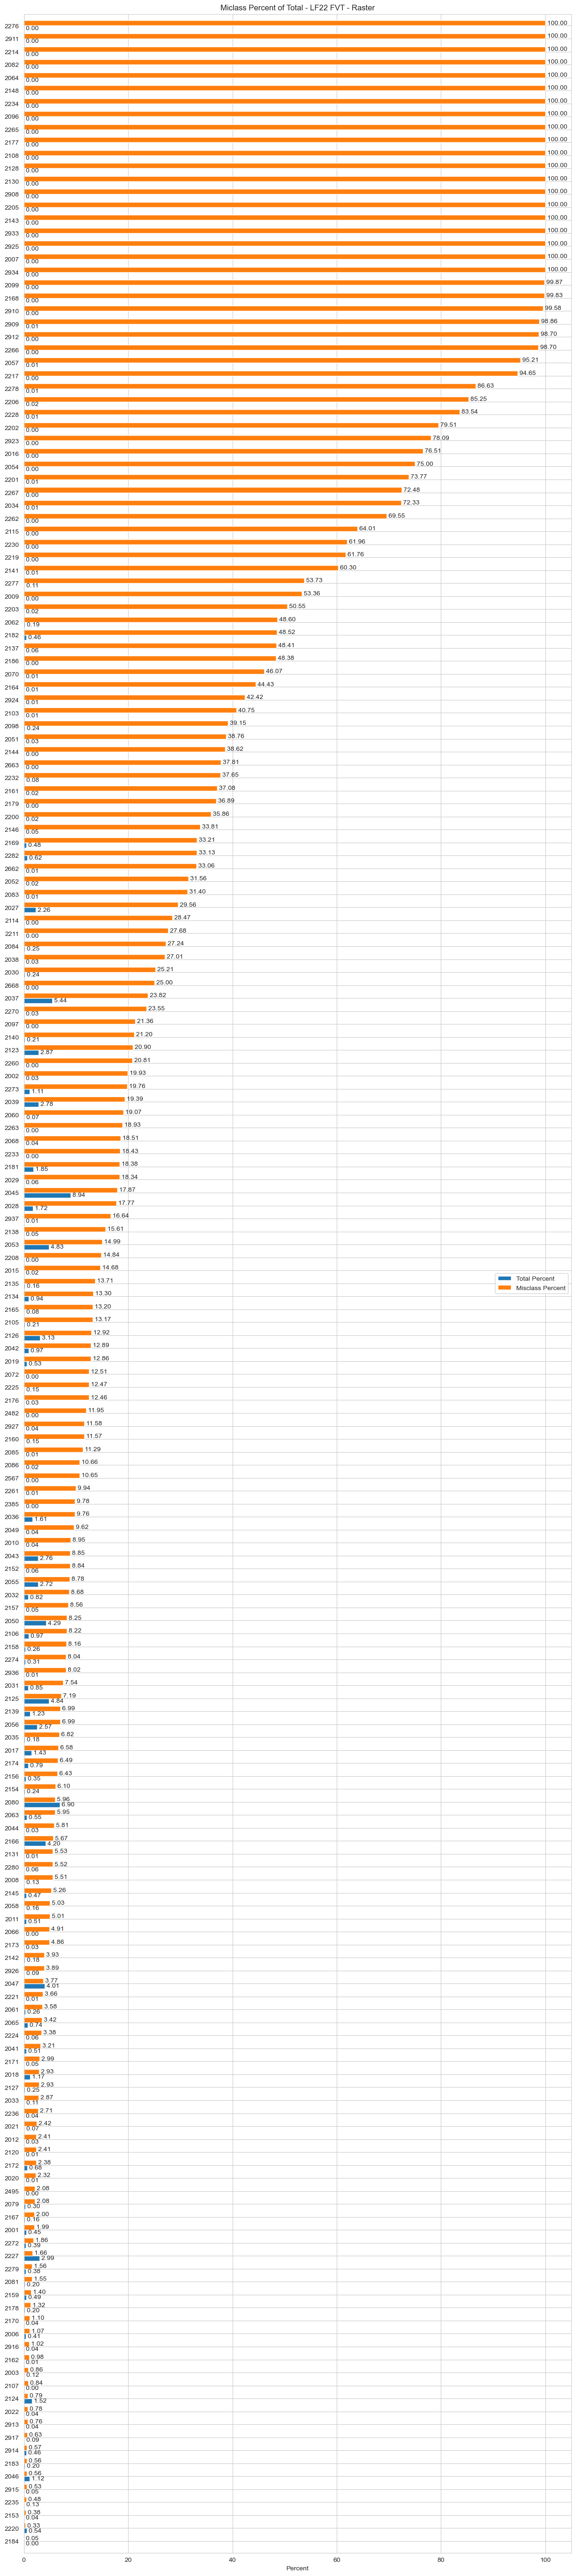

In [ ]:
# Subset to misclassified observations
misclass = df.loc[~(df['Original'] == df['Predictions'])]

# Subset the full dataset to only include FVT classes in the misclassed data
total = df.loc[df['Original'].isin(misclass['Original'].unique())]

# Create a dictionary of the above dataset to pass to the plotting function
df_dict = {'total' : total,
           'misclass' : misclass}

# Plot the data
metric = 'Percent'
title = "Miclass Percent of Total - LF22 FVT - Raster"
plot_percent_total(df_dict=df_dict, group_var='Original_FVT_NAME', metric=metric, title=title, figsize=(15, 70))

##  __FVT Pyrologic Similarity  -- Raster__
Note that these metrics are based on disturbed cells only. 


### Read and Process Data

In [18]:
# Read in data 
raster_fpaths_dict = {
    "FVT_Original" : paths_dict['og_FVT_raster'],
    "FVT_Predictions" : paths_dict['pred_FVT_raster'],
    "F40_Original" : paths_dict['og_F40_raster'],
    "F40_Predictions" : paths_dict['pred_F40_with_FVT_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)
df.head()


RasterioIOError: \\pnl\projects\BPAWildfire\data\Landfire\fuels_modeling\Fuel Attributes Model\..\LF_raster_data\bpa_service_territory\_predicted_rasters\LF22_F40_Pred_with_Pred_FVT_2024-05-14_16-57-02.tif: TIFFReadDirectory:Failed to read directory at offset 3195062082

In [ ]:
# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]
print(f"After removing null points: {df.shape[0]}")

# Filter out points that weren't disturbed
df = df.loc[~(df['LF22_FDST'] == 0)]
print(f"After removing undisturbed points: {df.shape[0]}")

# Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
df = df.loc[~df['Original'].isin(fvt_filter)]

In [ ]:
# Get results
results_dict = {
  "FVT_accuracy" : accuracy_score(df['FVT_Original'], df['FVT_Predictions']),
  "F40_accuracy" : accuracy_score(df['F40_Original'], df['F40_Original'])
}

results = pd.DataFrame([results_dict])
print(results)

### Add in match/no-match features

In [ ]:
# Create features based on whether predictions were accurate
df['FVT_Correct'] = df['FVT_Original'] == df['FVT_df']
df['F40_Correct'] = df['F40_Original'] == df['F40_df']
df.head()

### Calculate adjusted FVT accuracy
The adjusted FVT accuracy considers the FVT to be correct if: 
1. The FVT was correctly classified, or
2. The FVT was incorrectly classified, but the F40 was correctly classified

The ultimate goal of this process is to use the FVT raster as a predictor in the F40 model. Therefore, if the FVT was incorrectly classified but the F40 was correctly classified then we consider the FVT to be 'pyrologically similar' and correct for our purposes. 

In [ ]:
# What is the overall accuracy of the FVT model considering 'pyrologic similarity'? 
FVT_corr_cnt = df.loc[df['FVT_Correct'] == True].shape[0]
FVT_corr_perc = round(FVT_corr_cnt / df.shape[0] * 100, 2)

FVT_incorr_F40_corr_cnt = df.loc[(df['FVT_Correct'] ==  False) & (df['F40_Correct']) == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / df.shape[0] * 100, 2)

FVT_acc_adj_cnt = FVT_corr_cnt + FVT_incorr_F40_corr_cnt
FVT_acc_adj_perc = round(FVT_acc_adj_cnt / df.shape[0] * 100, 2)

print(f"Overall FVT Accuracy: {FVT_corr_perc}% ({FVT_corr_cnt} out of {df.shape[0]})")
print(f"Frequency of incorrect FVTs with correct F40s: {FVT_incorr_F40_corr_perc}% ({FVT_incorr_F40_corr_cnt} out of {df.shape[0]})")
print(f"Adjusted FVT Accuracy: {FVT_acc_adj_perc}% ({FVT_acc_adj_cnt} out of {df.shape[0]})")


Overall FVT Accuracy: 89.41% (144591 out of 161723)
Frequency of incorrect FVTs with correct F40s: 3.03% (4901 out of 161723)
Adjusted FVT Accuracy: 92.44% (149492 out of 161723)


### F40 Misclassification Differences
For cases where FVT is incorrect and F40 is incorrect, what is the difference between the acutal and predicted F40? 

F40 classes with similar values can generally be considered to have similar fuels characteristics, so a difference of 1 would likely have little impact on the fire behavior modeling. Note that differences in multiples of 20 indicate that the fuels "parent class" was misclassified due to how the data is structured (e.g. a difference of 20 may indicate that a 'Grass' was classified as a 'Grass-Shrub') - hence the clustered nature of the graph. 

C:\Users\mcco573\AppData\Local\Temp\ipykernel_21444\3037083262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F40_diff'] = df['LF22_F40'] - df['PRED_LF22_F40']


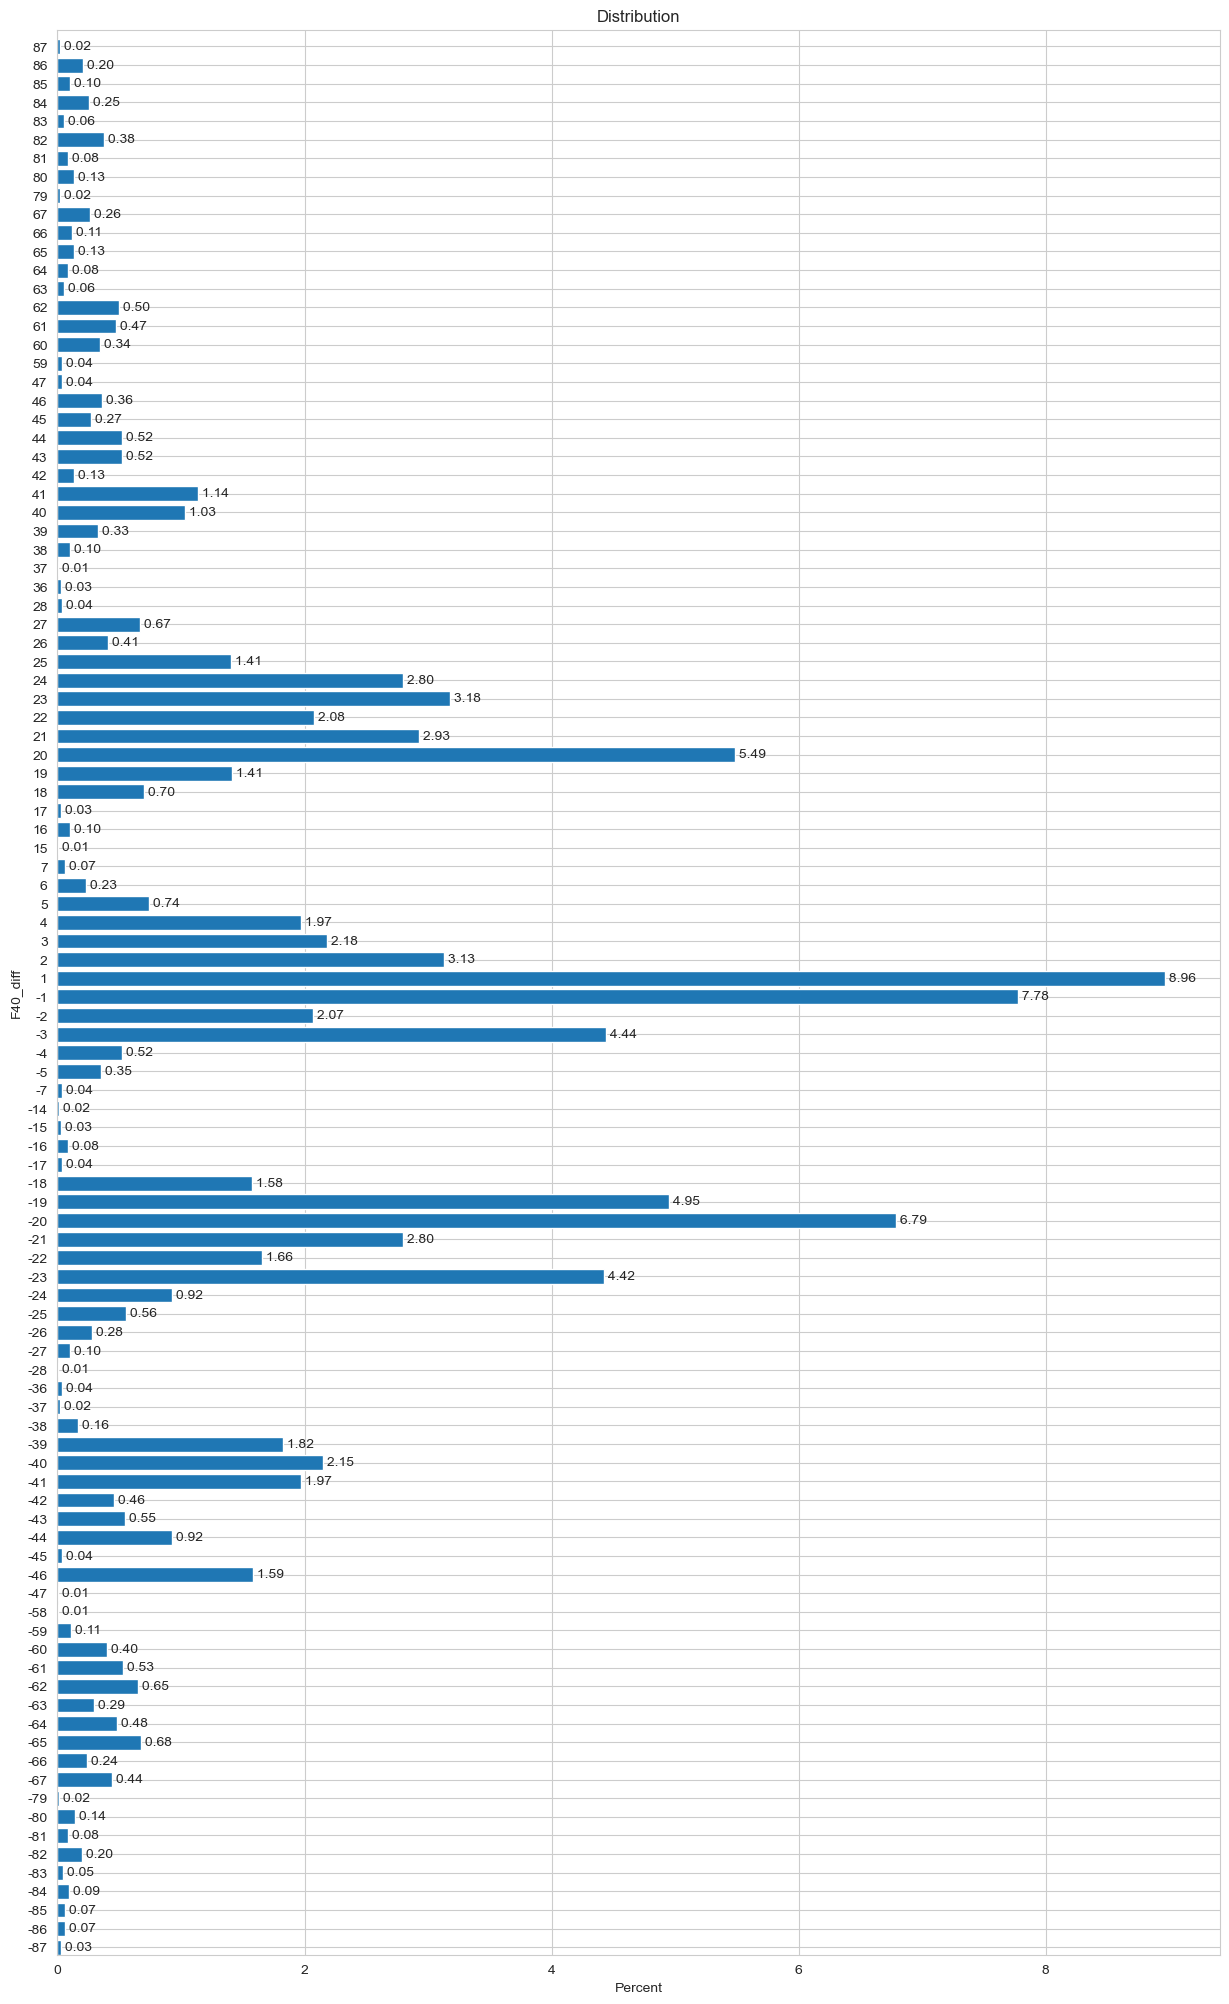

In [ ]:
misclass = df.loc[(df['FVT_Correct'] == False) & (df['F40_Correct'] == False)]
misclass['F40_diff'] = misclass['LF22_F40'] - misclass['PRED_LF22_F40']

plot_distribution(misclass, group_var='F40_diff', metric='Percent', sort=False, figsize=(15, 25))

### Further break down the results
Further statistics to explore how the predicted FVT values influence the F40 classification.

In [ ]:
total_cnt = len(df)

# Get overall F40 accuracy
F40_correct_cnt = df['F40_Correct'].sum()
F40_overall_acc = round(F40_correct_cnt / total_cnt * 100, 2)

print(f"The overall F40 accuracy is: {F40_overall_acc}% ({F40_correct_cnt} out of {total_cnt})")

# Get overall FVT accuracy
FVT_correct_cnt = df['FVT_Correct'].sum()
FVT_overall_acc = round(FVT_correct_cnt / total_cnt * 100, 2)

print(f"The overall FVT accuracy is: {FVT_overall_acc}% ({FVT_correct_cnt} out of {total_cnt})")


The overall F40 accuracy is: 76.01% (122924 out of 161723)
The overall FVT accuracy is: 89.41% (144591 out of 161723)


In [ ]:
# How did the F40 model perform with correct FVT classifications? 
FVT_corr_F40_incorr_cnt = df.loc[(df['FVT_Correct'] == True) & (df['F40_Correct'] == False)].shape[0]
FVT_corr_F40_incorr_perc = round(FVT_corr_F40_incorr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_incorr_perc}% of observations had correct FVTs and incorrect F40s ({FVT_corr_F40_incorr_cnt} out of {total_cnt})")

FVT_corr_F40_corr_cnt = df.loc[(df['FVT_Correct'] == True) & (df['F40_Correct'] == True)].shape[0]
FVT_corr_F40_corr_perc = round(FVT_corr_F40_corr_cnt / total_cnt * 100, 2)
print(f"{FVT_corr_F40_corr_perc}% of observations had correct FVTs and correct F40s ({FVT_corr_F40_corr_cnt} out of {total_cnt})")


16.43% of observations had correct FVTs and incorrect F40s (26568 out of 161723)
72.98% of observations had correct FVTs and correct F40s (118023 out of 161723)


In [ ]:
# How did the model perform with incorrect FVT classifications? 
FVT_incorr = df.loc[df['FVT_Correct'] == False]
FVT_incorr_total = FVT_incorr.shape[0]

FVT_incorr_F40_corr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == True].shape[0]
FVT_incorr_F40_corr_perc = round(FVT_incorr_F40_corr_cnt / FVT_incorr_total * 100, 2)

FVT_incorr_F40_incorr_cnt = FVT_incorr.loc[FVT_incorr['F40_Correct'] == False].shape[0]
FVT_incorr_F40_incorr_perc = round(FVT_incorr_F40_incorr_cnt / FVT_incorr_total * 100, 2)

print(f"Of observations where FVT was misclassed ({FVT_incorr_total}): ")
print(f"{FVT_incorr_F40_corr_perc}% of observations had correct F40 classifications ({FVT_incorr_F40_corr_cnt} of {FVT_incorr_total})")
print(f"{FVT_incorr_F40_incorr_perc}% of observations had incorrect F40 classifications ({FVT_incorr_F40_incorr_cnt} of {FVT_incorr_total})")

Of observations where FVT was misclassed (17132): 
28.61% of observations had correct F40 classifications (4901 of 17132)
71.39% of observations had incorrect F40 classifications (12231 of 17132)


## __Visualizations__

### __Plot the Class Distribution__
Plots the distribution of the variable of interest. Can be set to display the raw counts for each class or the percentage of the dataste that the class accounts for. 

In [ ]:
def plot_distribution(df, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots the distribution of group_var. 'metric' can be set to either 'Count' or 'Percent' to change the display type. 
    The 'sort' argument specifies whether to sort the display in order from most common to least common. 
    """
    # Get count of target class
    df_gp = df.groupby(group_var).count().reset_index()
    df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

    # Get classes proportional representation
    df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
    df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str
    if sort == True: 
        df_gp = df_gp.sort_values(by="Count", ascending=True)

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    hbars = ax.barh(df_gp[group_var],
                df_gp[metric],
                align='center')
    ax.set(title=title,
        xlabel= f'{metric}', 
        ylabel=f'{group_var}')  
    ax.bar_label(hbars, fmt=" %.2f")
    
    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y(), ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Compare the Distribution of the Misclasses vs. Actual__
Plot a graph to see how the distribution of the misclasses compares with the distribution of the true classes. Metric can be set to 'Count' for raw counts or 'Percent'. If metric='Percent', then the 'total' value represents the percent representation of that class in the original dataset (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 7.47% of observations in the true dataset), and the 'Misclass' value is the percent proportion of the misclassification data (e.g. Tr Northern Rocky Mountain Dry-Mesic Montane Mixed Conifer Forest accounts for 9.91% of all misclassed observations).

In [ ]:
def plot_comparison_distribution(df_dict, group_var, metric='Count', sort=True, title=f'Distribution', figsize=(15, 50)):
    """
    Plots distributions of the true vs. misclassed datasets.

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # sort values before plotting
    if sort == True:
        df_gp_dict['misclass'] = df_gp_dict['misclass'].sort_values(by=metric)
        df_gp_dict['total'] = df_gp_dict['total'].reindex(df_gp_dict['misclass'].index)

    # Set up to plot side-by-side
    ind = np.arange(len(df_gp_dict['misclass'])) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_bar = ax.barh(ind+width/2, df_gp_dict['total'][metric], width, label='Total')
    misclass_bar = ax.barh(ind-width/2, df_gp_dict['misclass'][metric], width, label='Misclass')

    ax.set_title(title)
    ax.set_xlabel(f'{metric}')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['misclass'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_bar, fmt=" %.2f")
    ax.bar_label(misclass_bar, fmt=" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

### __Assess the Proportion of the Actual Values that were Misclasses__
Create a plot to display the percentage of each class that was misclassified alongside that classes total representation in the dataset. Setting the 'metric' argument will only affect how the total representation is displayed - by 'Count' or 'Percent' - the misclassified proportion will not change. 

In [ ]:
# Plots the percent of the total class the misclass count is
def plot_percent_total(df_dict, group_var, sort=True, title=f'Distribution', metric='Count', figsize=(15, 50)):
    """
    Plots the proportion of each class that was misclassified, alongside its total representation in the dataset. 

    Arguments:
    df_dict: Dictionary with the keys 'total' and 'misclass'. The corresponding values should be dataframes, where the 'total'
    dataframe is the original predictions subset to only include target classes found in the 'misclass' set and the 'misclass' dataframe
    is the original predictions subset to observations where the predicted target value does not match the actual. 

    metric = 'Count' / 'Percent' : Changes how to view the data - by raw counts or by proportions. 

    sort = True/False : Choose whether to sort the data before displaying it. 
    """
    
    df_gp_dict = {}
    
    # Aggregate the data
    for key, df in df_dict.items():
        # Get count of target class
        df_gp = df.groupby(group_var).count().reset_index()
        df_gp = df_gp.iloc[:, 0:2].rename(columns={df_gp.columns[1] : 'Count'})

        # Get classes proportional representation
        df_gp['Percent'] = df_gp['Count'] / df_gp['Count'].sum() * 100
        df_gp[group_var] = df_gp[group_var].astype('str')  # For plotting change FVT to str

        df_gp_dict[key] = df_gp

    # Calculate percent of total 
    total_perc = df_gp_dict['misclass']['Count'] / df_gp_dict['total']['Count'] * 100

    # Sort the data before plotting
    if sort == True:
        total_perc = total_perc.sort_values()
        df_gp_dict['total'] = df_gp_dict['total'].reindex(total_perc.index)

    # Set up to plot side-by-side
    ind = np.arange(len(total_perc)) # The y locations for groups
    width = 0.4

    ## Visualize the distribution
    fig, ax = plt.subplots(figsize=figsize)
    total_count_bar = ax.barh(ind-width/2, df_gp_dict['total'][metric], width, label=f'Total {metric}')
    total_perc_bar = ax.barh(ind+width/2, total_perc, width, label='Misclass Percent')
  
    ax.set_title(title)
    ax.set_xlabel('Percent')
    ax.set_yticks(ind)
    ax.set_yticklabels(df_gp_dict['total'][group_var].values)
    ax.legend(loc='right')
    ax.bar_label(total_perc_bar, fmt=" %.2f")
    ax.bar_label(total_count_bar, fmt=f" %.2f")

    # Remove whitespace at margins
    plt.ylim(ax.patches[0].get_y()-0.5, ax.patches[-1].get_y() + ax.patches[-1].get_height()+0.5)

    plt.show()

## __Data Processing__

### __Create Data Dictionaries to Append Features__
Some features are separate attributes of the LANDFIRE dataset (e.g. BPS Fire Regime) and others are useful for results analysis (e.g. FDst attributes). These can be mapped to points using LANDFIRE CSVs. The below creates dictionaries to perform that mapping. 

This function is called by join_features.

In [ ]:
def read_ref_data(ref_data_dir=paths_dict['ref_data_dir']):
    """
    Returns a dictionary of dictionaries of mappings between LANDFIRE raster values and other attributes associated with those values. 
    """
    data_dir = ref_data_dir
    LF22_FVT_fname = "LF22_FVT_230.csv"
    LF22_FVC_fname = "LF22_FVC_230.csv"
    LF22_FVH_fname = "LF22_FVH_230.csv"
    
    # Create empty dictionary
    LF_ref_dicts = {}

    # Join fuel type names from values
    LF22_FVT_df = pd.read_csv(os.path.join(data_dir, LF22_FVT_fname))
    LF_ref_dicts['Original_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
    LF_ref_dicts['Predicted_FVT_NAME'] = dict(LF22_FVT_df[['VALUE', 'EVT_FUEL_N']].values)
   
    # Join fuel cover names from values
    LF22_FVC_df = pd.read_csv(os.path.join(data_dir, LF22_FVC_fname))
    LF_ref_dicts['Original_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVC_NAME'] = dict(LF22_FVC_df[['VALUE', 'CLASSNAMES']].values)

    # Join fuel height names from values
    LF22_FVH_df = pd.read_csv(os.path.join(data_dir, LF22_FVH_fname))
    LF_ref_dicts['Original_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)
    LF_ref_dicts['Predicted_FVH_NAME'] = dict(LF22_FVH_df[['VALUE', 'CLASSNAMES']].values)

    return LF_ref_dicts
                         
        

### __Append Features using Data Dictionaries__
Append in selected features using the LANDFIRE data dictionaries.

__Note:__ Items in feature_list must be in the source_layers dictionary. 

In [ ]:
def create_features(df, feature_list = ['Original_FVT_NAME', 'Predicted_FVT_NAME'], source_layers = {
        'Original_FVT_NAME' : 'LF22_FVT', 
        'Predicted_FVT_NAME' : 'Predicted_LF22_FVT',
        'Original_FVC_NAME' : 'LF22_FVC', 
        'Predicted_FVC_NAME' : 'Predicted_LF22_FVC',
        'Original_FVH_NAME' : 'LF22_FVH', 
        'Predicted_FVH_NAME' : 'Predicted_LF22_FVH',
    }):
    """
    Returns the sample_points layer with the features in feature_list appended. 

    Items in feature_list must be in the source_layers dictionary.  
    """
    # Get names associated with FVT values
    LF_ref_dicts = read_ref_data()

    # Create the feature
    for feature in feature_list:
        df[feature] = df[source_layers[feature]].map(LF_ref_dicts[feature]).copy()

    # Get Prefix Code -- used to asses ecological similarity
    if feature_list == ['Original_FVT_NAME', 'Predicted_FVT_NAME']:
        df['Original_FVT_Prefix'] = df['Original_FVT_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVT_Prefix'] = df['Predicted_FVT_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVC_NAME', 'Predicted_FVC_NAME']:
        df['Original_FVC_Prefix'] = df['Original_FVC_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVC_Prefix'] = df['Predicted_FVC_NAME'].str.split(" ",expand=True)[0]
    elif feature_list == ['Original_FVH_NAME', 'Predicted_FVH_NAME']:
        df['Original_FVH_Prefix'] = df['Original_FVH_NAME'].str.split(" ", expand=True)[0]
        df['Predicted_FVH_Prefix'] = df['Predicted_FVH_NAME'].str.split(" ",expand=True)[0]

    return df

# __FVC Predictions Evaluation - Sample Points__
---

In [49]:
pred_fpath = os.path.join(paths_dict['pred_data_dir'], paths_dict['FVC_pred_data_fname'])
predictions = pd.read_csv(pred_fpath)
create_features(predictions, feature_list=['Original_FVC_NAME', 'Predicted_FVC_NAME'])
predictions.head()

Unnamed: 0  LF22_FVT  LF20_FVT  LF16_FVT  LF16_EVT  LF14_EVT  LF22_FDST  \
0       60800      2181      2181      2080      7080      3181        113   
1       64725      2043      2030      2030      7030      3035        612   
2      104285      2166      2050      2166      7166      3235        513   
3      199600      2182      2181      2125      7125      3181        123   
4        1022      2105      2105      2105      7105      3105        112   

   ZONE   BPS  ASPECT  ...  FDST_SEV           FDST_TSD   EVT_PHYS  \
0    18  1238     117  ...       Low   Six to Ten Years  Shrubland   
1     2   767       2  ...       Low  Two to Five Years    Conifer   
2    21   715     279  ...       Low   Six to Ten Years    Conifer   
3     8   668     144  ...  Moderate   Six to Ten Years  Shrubland   
4     3   565     245  ...       Low  Two to Five Years  Shrubland   

                             EVT_GP_N           EVT_CLASS  Predicted_LF22_FVC  \
0  Big Sagebrush Shrubland and Steppe           Shrubland                 125   
1     Conifer-Oak Forest and Woodland    Open tree canopy                 107   
2     Douglas-fir Forest and Woodland  Closed tree canopy                 104   
3  Big Sagebrush Shrubland and Steppe           Shrubland                 125   
4                           Chaparral           Shrubland                 115   

             Original_FVC_NAME           Predicted_FVC_NAME  \
0   Herb Cover >= 50 and < 60%   Herb Cover >= 50 and < 60%   
1   Tree Cover >= 70 and < 80%   Tree Cover >= 70 and < 80%   
2   Tree Cover >= 40 and < 50%   Tree Cover >= 40 and < 50%   
3   Herb Cover >= 50 and < 60%   Herb Cover >= 50 and < 60%   
4  Shrub Cover >= 50 and < 60%  Shrub Cover >= 50 and < 60%   

   Original_FVC_Prefix  Predicted_FVC_Prefix  
0                 Herb                  Herb  
1                 Tree                  Tree  
2                 Tree                  Tree  
3                 Herb                  Herb  
4                Shrub                 Shrub  

[5 rows x 34 columns]

## Check Overall Accuracy

In [50]:
match = predictions.loc[predictions['LF22_FVC'] == predictions['Predicted_LF22_FVC']]
match_perc = len(match) / len(predictions) * 100
print(f'Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Mismatch Count: 437 of 38537
Matching Percent: 98.87%


## Check Prefix Matches 

In [51]:
match = predictions.loc[predictions['Original_FVC_Prefix'] == predictions['Predicted_FVC_Prefix']]
match_perc = len(match) / len(predictions) * 100
print(f'Prefix Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Prefix Mismatch Count: 94 of 38537
Matching Percent: 99.76%


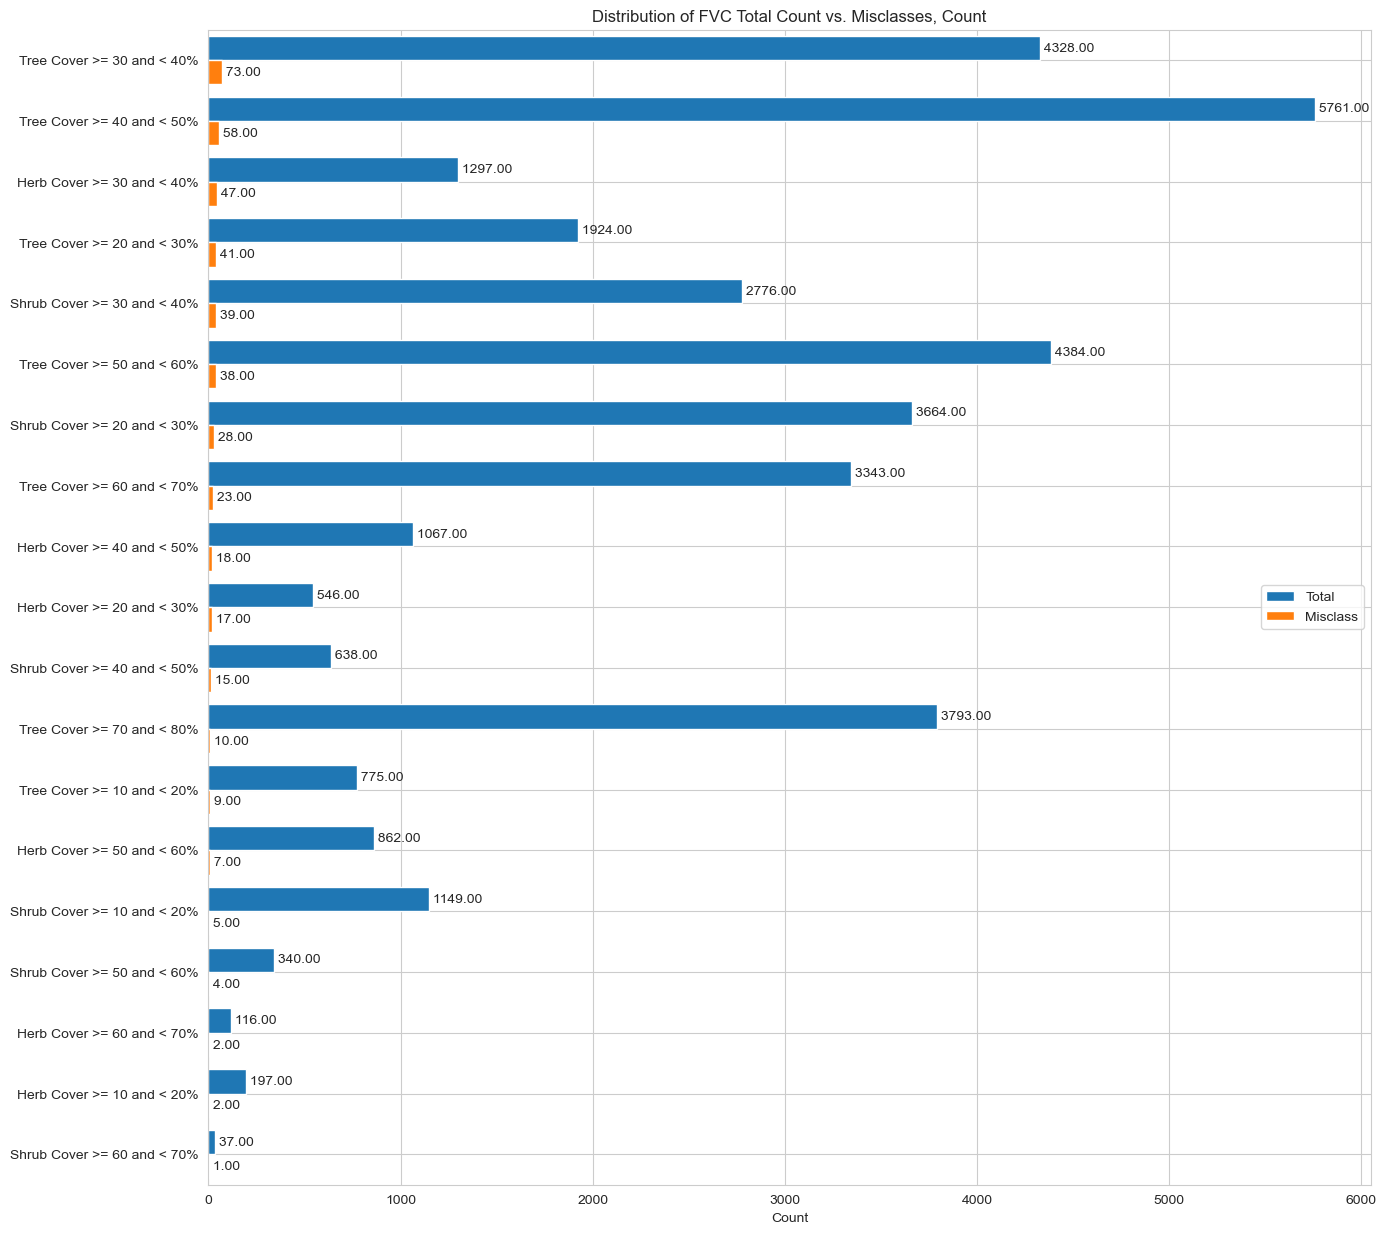

In [52]:
misclass = predictions.loc[~(predictions['LF22_FVC'] == predictions['Predicted_LF22_FVC'])]
total = predictions.loc[predictions['LF22_FVC'].isin(misclass['LF22_FVC'].unique())]


df_dict = {'total' : total,
           'misclass' : misclass}

metric = 'Count'
title = f'Distribution of FVC Total Count vs. Misclasses, {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original_FVC_NAME', metric=metric, title=title, figsize=(15, 15))


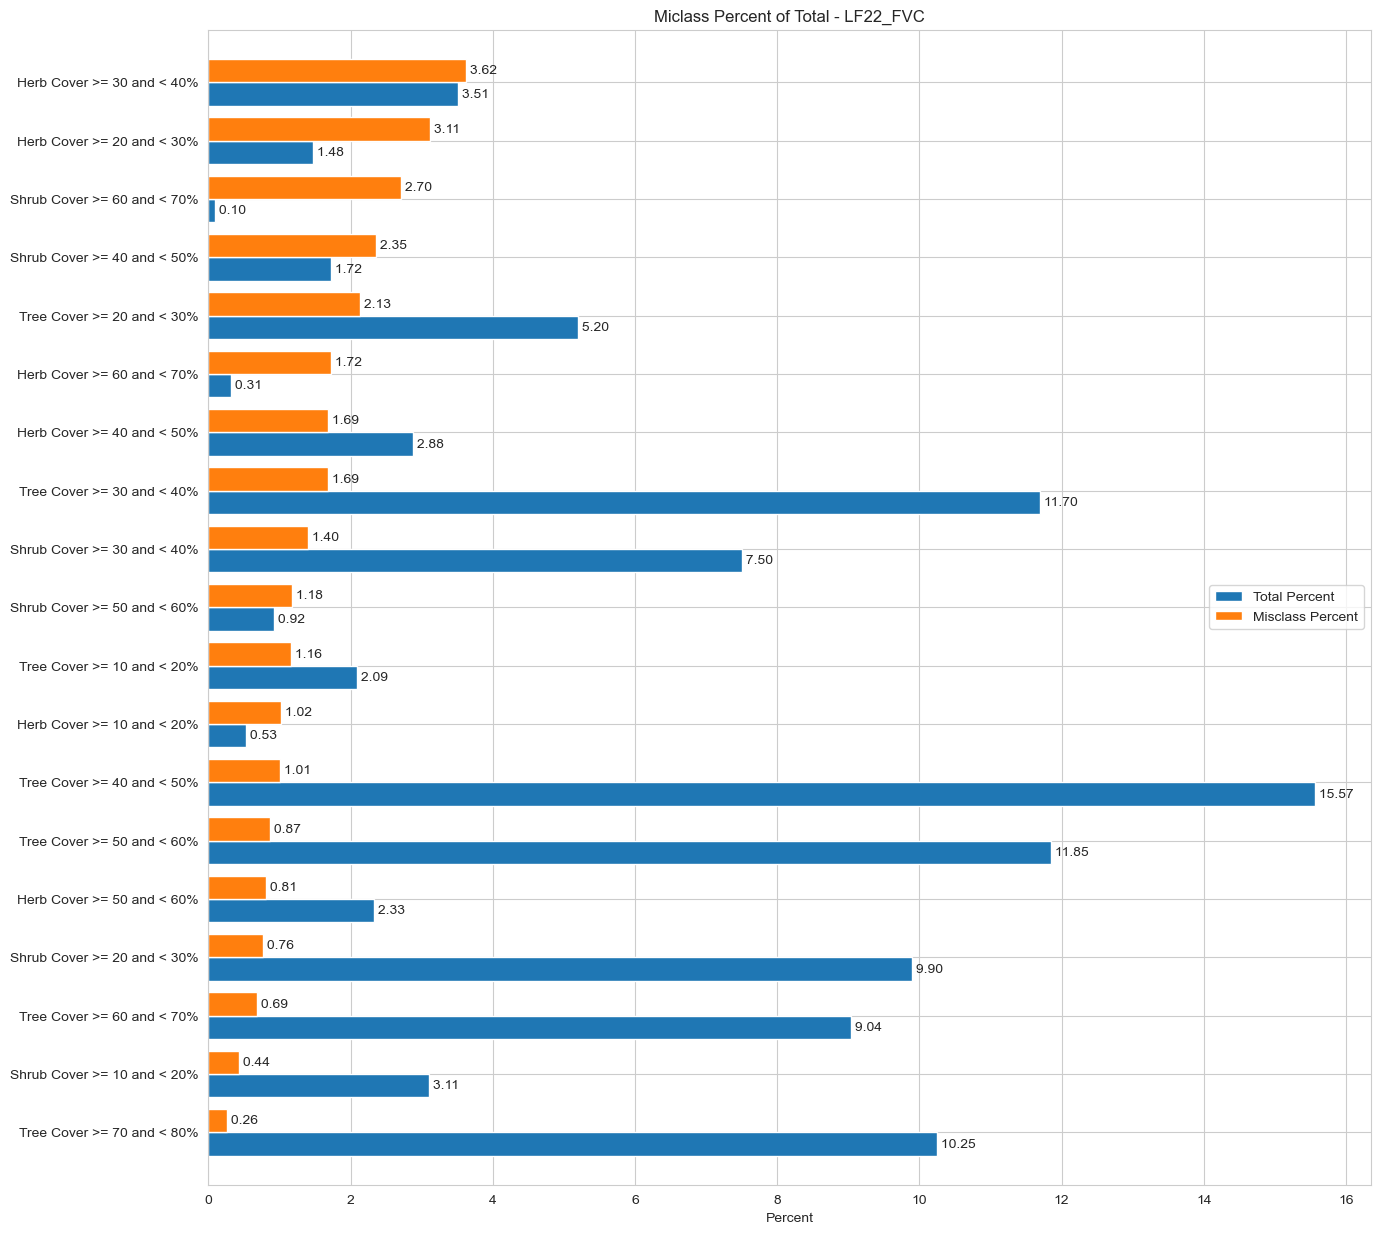

In [53]:
misclass = predictions.loc[~(predictions['LF22_FVC'] == predictions['Predicted_LF22_FVC'])]
total = predictions.loc[predictions['LF22_FVC'].isin(misclass['LF22_FVC'].unique())]


df_dict = {'total' : total,
           'misclass' : misclass}

metric = 'Percent'
title = "Miclass Percent of Total - LF22_FVC"
plot_percent_total(df_dict=df_dict, group_var='Original_FVC_NAME', metric=metric, title=title, figsize=(15, 15))

## Misclassifications based on FDST

Are there certain FDST categories that are more commonly misclassified?  

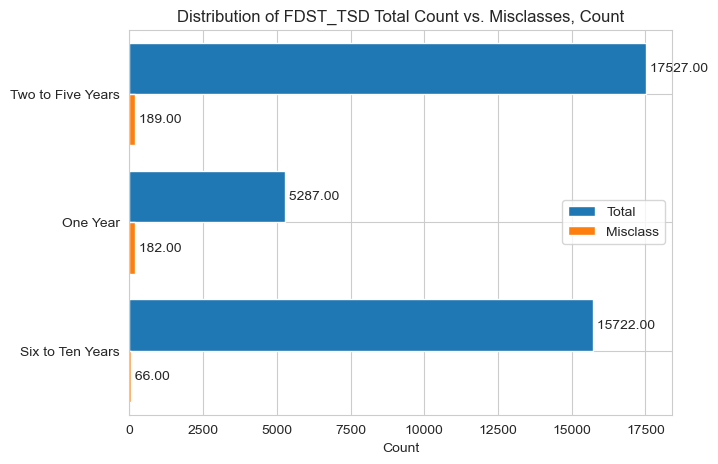

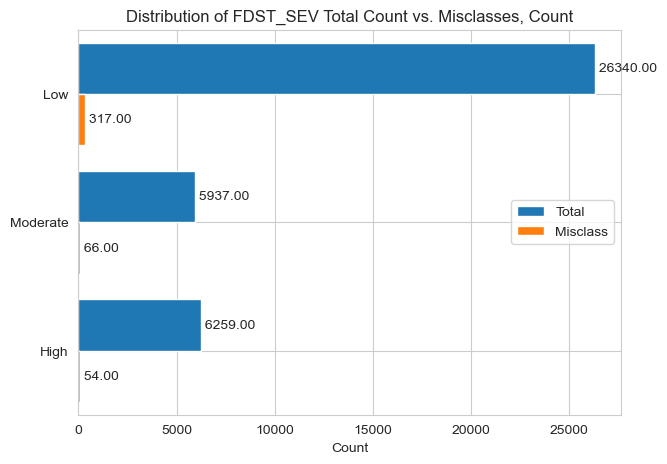

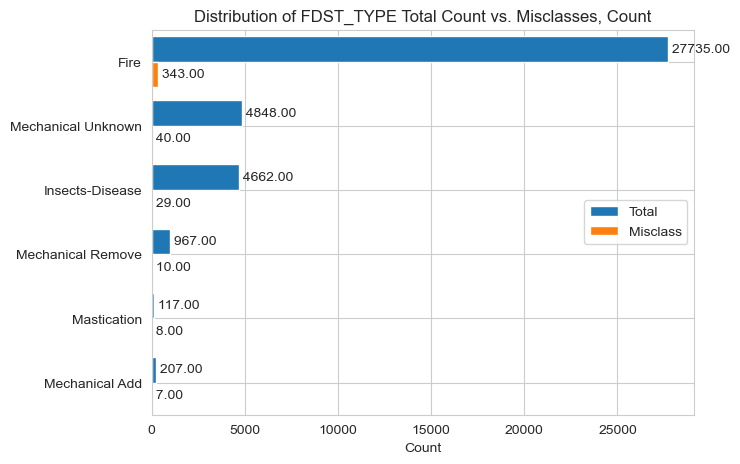

In [54]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVC'] == predictions['Predicted_LF22_FVC'])]

# Drop FDST_TYPE groups not in misclass
mis_type_gps = misclass['FDST_TYPE'].unique()
preds_dropped = predictions.loc[predictions['FDST_TYPE'].isin(mis_type_gps)]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Count'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_comparison_distribution(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))

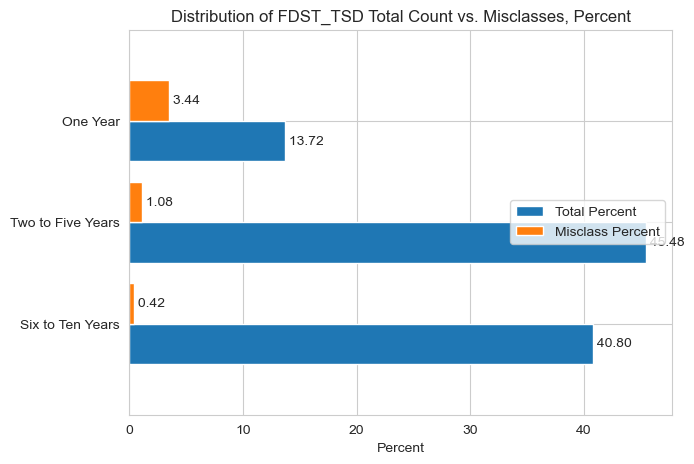

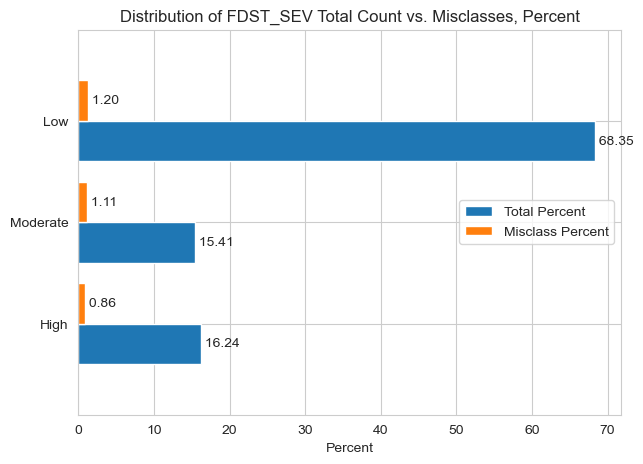

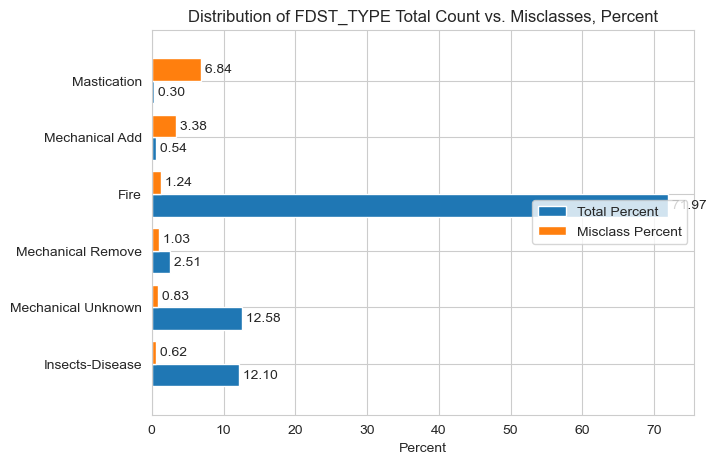

In [55]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVC'] == predictions['Predicted_LF22_FVC'])]

# Drop FDST_TYPE groups not in misclass
mis_type_gps = misclass['FDST_TYPE'].unique()
preds_dropped = predictions.loc[predictions['FDST_TYPE'].isin(mis_type_gps)]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Percent'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_percent_total(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))

# __FVC Predictions Evaluation - Raster__ 

## __Summary Statistics__ 

In [14]:
# Read in data 
raster_fpaths_dict = {
    "Predictions" : paths_dict['pred_FVC_raster'],
    "Original" : paths_dict['og_FVC_raster'],
    "LF22_FDST"  : paths_dict['LF22_FDST']
    }

data_dict = {}
for var, item in raster_fpaths_dict.items():
    with rasterio.open(item) as src:
        data = src.read()
        data_dict[var] = data.ravel()

# Create dataframe from dictionary of predictions/original
df = pd.DataFrame(data_dict)
df.head()


Predictions  Original  LF22_FDST
0        32767     32767      -9999
1        32767     32767      -9999
2        32767     32767      -9999
3        32767     32767      -9999
4        32767     32767      -9999

In [15]:
# Process the data
# Remove observations with -9999/-1111 in any field 
df = df.loc[~df.isin([-1111, -9999]).any(axis=1)]
print(f"After removing null points: {df.shape[0]}")

# Filter out points that weren't disturbed
df = df.loc[~(df['LF22_FDST'] == 0)]
print(f"After removing undisturbed points: {df.shape[0]}")

# Filter out agricultural and developed points
developed_fvt = list(range(20,33)) + list(range(2901,2906))
ag_fvt = [80, 81, 82] + list(range(2960, 2971))
fvt_filter = developed_fvt + ag_fvt
df = df.loc[~df['Original'].isin(fvt_filter)]
df.head()


After removing null points: 1094586641
After removing undisturbed points: 145899760


Predictions  Original  LF22_FDST
76563462          129       106        613
76563463          129       107        613
76563464          125       108        623
76563465          125       107        623
76563466           12       108        613

In [16]:
# Get results
results_dict = {
  "accuracy" : accuracy_score(df['Original'], df['Predictions']),
  "recall" : recall_score(df['Original'], df['Predictions'], average='macro'),
  "precision" : precision_score(df['Original'], df['Predictions'], average='macro')
}
results = pd.DataFrame([results_dict])
print(results)

c:\ProgramData\miniconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   accuracy    recall  precision
0  0.069657  0.067317   0.079862


c:\ProgramData\miniconda3\envs\geospatial\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save out results
results.to_csv(os.path.join(paths_dict['results_outdir'], paths_dict['FVT_results_out_fname']))

accuracy    recall  precision
0   0.88337  0.667231   0.563552

# __FVH Predictions Evaluation__
----

In [56]:
pred_fpath = os.path.join(paths_dict['pred_data_dir'], paths_dict['FVH_pred_data_fname'])
predictions = pd.read_csv(pred_fpath)
create_features(predictions, feature_list=['Original_FVH_NAME', 'Predicted_FVH_NAME'])
predictions.head()

Unnamed: 0  LF22_FVT  LF20_FVT  LF16_FVT  LF16_EVT  LF14_EVT  LF22_FDST  \
0       57232      2172      2172      2172      7172      3028        512   
1      125763      2045      2045      2045      7045      3227        121   
2      132259      2039      2039      2036      7036      3036        511   
3       16423      2028      2028      2028      7028      3028        111   
4       88228      2227      2166      2166      7166      3166        113   

   ZONE  BPS  ASPECT  ...  FDST_SEV           FDST_TSD  EVT_PHYS  \
0     7  798     357  ...       Low  Two to Five Years   Conifer   
1     9  626     318  ...  Moderate           One Year   Conifer   
2     2  771     264  ...       Low           One Year   Conifer   
3     6  585     288  ...       Low           One Year   Conifer   
4    10  423     199  ...       Low   Six to Ten Years   Conifer   

                                            EVT_GP_N           EVT_CLASS  \
0  Douglas-fir-Grand Fir-White Fir Forest and Woo...    Open tree canopy   
1  Douglas-fir-Ponderosa Pine-Lodgepole Pine Fore...  Closed tree canopy   
2                                Sitka Spruce Forest  Closed tree canopy   
3  Douglas-fir-Grand Fir-White Fir Forest and Woo...  Closed tree canopy   
4                    Douglas-fir Forest and Woodland  Closed tree canopy   

   Predicted_LF22_FVH              Original_FVH_NAME  \
0                 623  Forest Height 21 - <25 meters   
1                 615  Forest Height 13 - <17 meters   
2                 619  Forest Height 17 - <21 meters   
3                 623  Forest Height 21 - <25 meters   
4                 619  Forest Height 17 - <21 meters   

              Predicted_FVH_NAME  Original_FVH_Prefix  Predicted_FVH_Prefix  
0  Forest Height 21 - <25 meters               Forest                Forest  
1  Forest Height 13 - <17 meters               Forest                Forest  
2  Forest Height 17 - <21 meters               Forest                Forest  
3  Forest Height 21 - <25 meters               Forest                Forest  
4  Forest Height 17 - <21 meters               Forest                Forest  

[5 rows x 34 columns]

## Check Overall Accuracy

In [57]:
match = predictions.loc[predictions['LF22_FVH'] == predictions['Predicted_LF22_FVH']]
match_perc = len(match) / len(predictions) * 100
print(f'Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Mismatch Count: 377 of 38537
Matching Percent: 99.02%


## Check Prefix Matches 

In [58]:
match = predictions.loc[predictions['Original_FVH_Prefix'] == predictions['Predicted_FVH_Prefix']]
match_perc = len(match) / len(predictions) * 100
print(f'Prefix Mismatch Count: {len(predictions) - len(match)} of {len(predictions)}')
print(f"Matching Percent: {round(match_perc, 2)}%")

Prefix Mismatch Count: 68 of 38537
Matching Percent: 99.82%


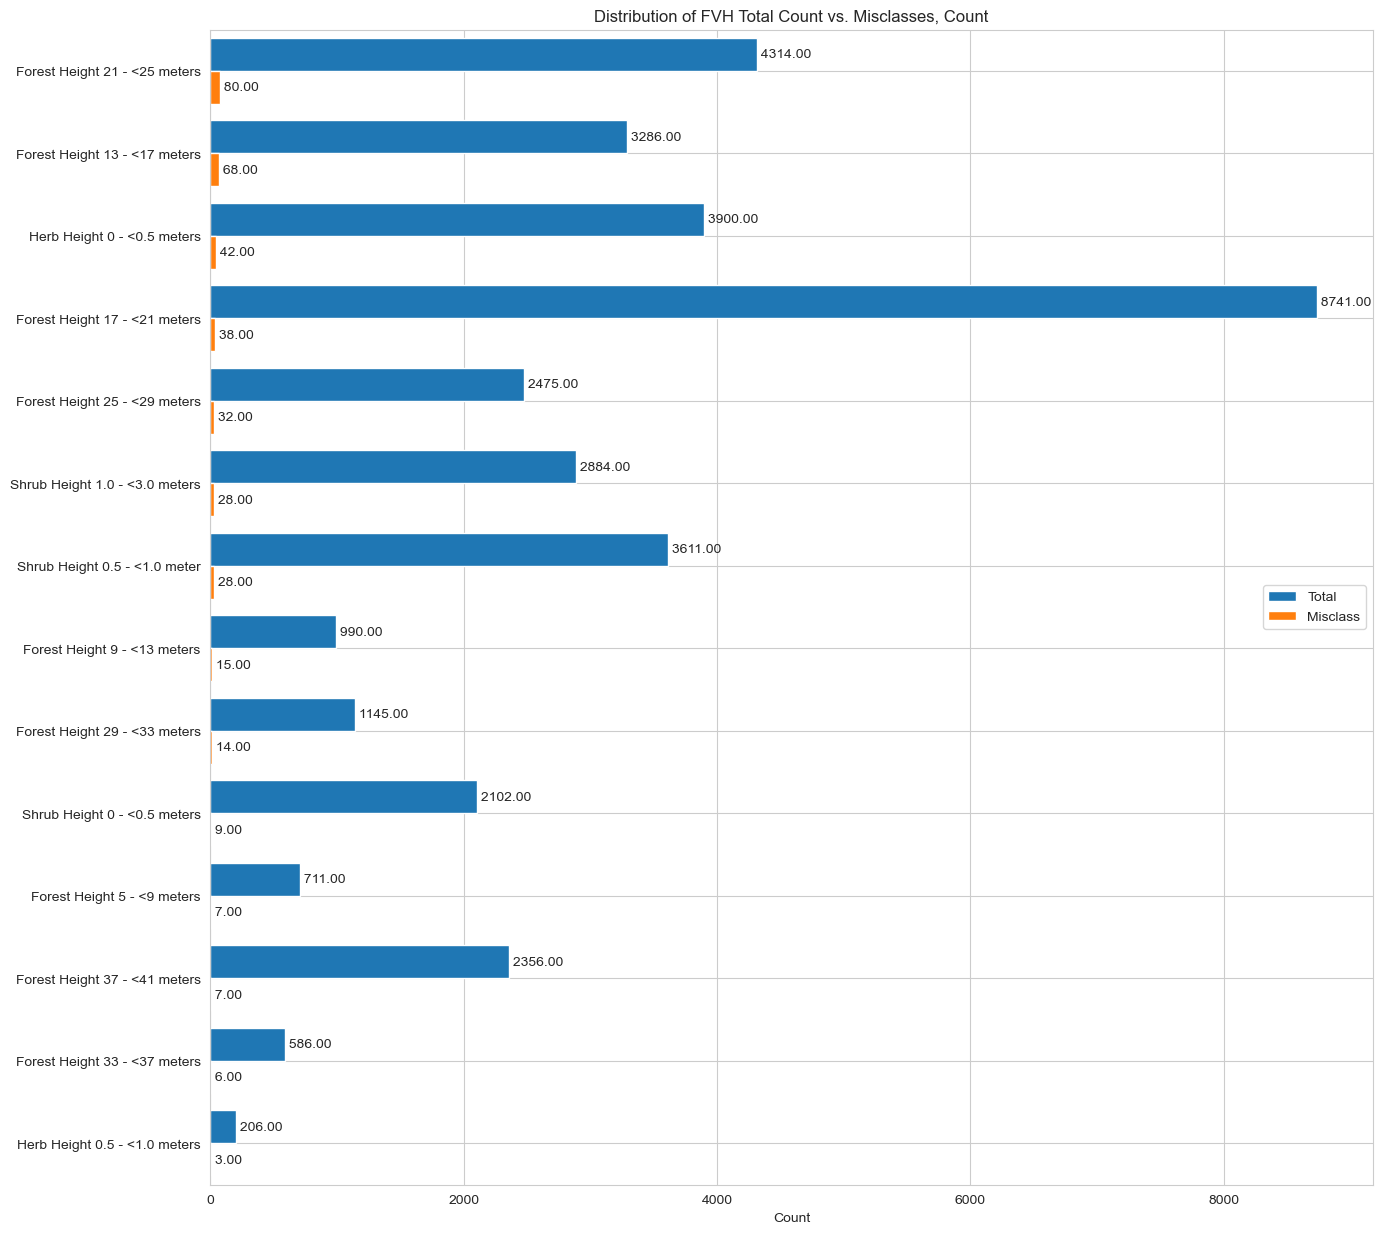

In [59]:
misclass = predictions.loc[~(predictions['LF22_FVH'] == predictions['Predicted_LF22_FVH'])]
total = predictions.loc[predictions['LF22_FVH'].isin(misclass['LF22_FVH'].unique())]


df_dict = {'total' : total,
           'misclass' : misclass}

metric = 'Count'
title = f'Distribution of FVH Total Count vs. Misclasses, {metric}'
plot_comparison_distribution(df_dict=df_dict, group_var='Original_FVH_NAME', metric=metric, title=title, figsize=(15, 15))


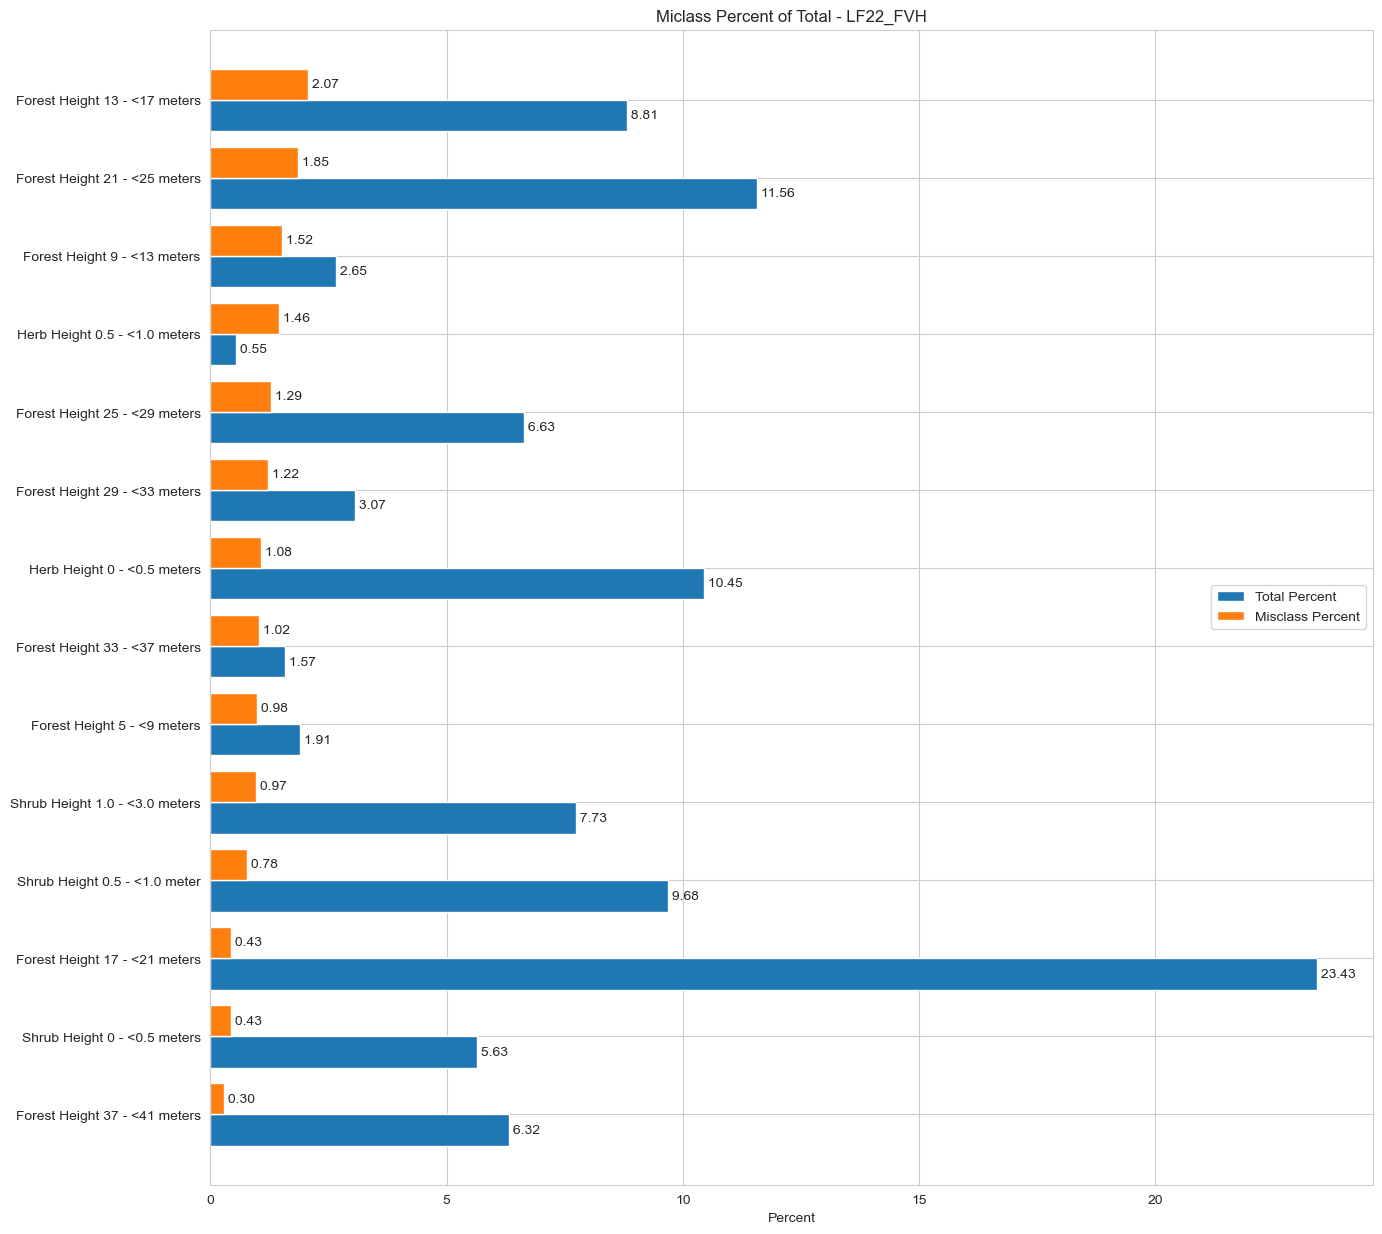

In [60]:
misclass = predictions.loc[~(predictions['LF22_FVH'] == predictions['Predicted_LF22_FVH'])]
total = predictions.loc[predictions['LF22_FVH'].isin(misclass['LF22_FVH'].unique())]


df_dict = {'total' : total,
           'misclass' : misclass}

metric = 'Percent'
title = "Miclass Percent of Total - LF22_FVH"
plot_percent_total(df_dict=df_dict, group_var='Original_FVH_NAME', metric=metric, title=title, figsize=(15, 15))

## Misclassifications based on FDST

Are there certain FDST categories that are more commonly misclassified?  

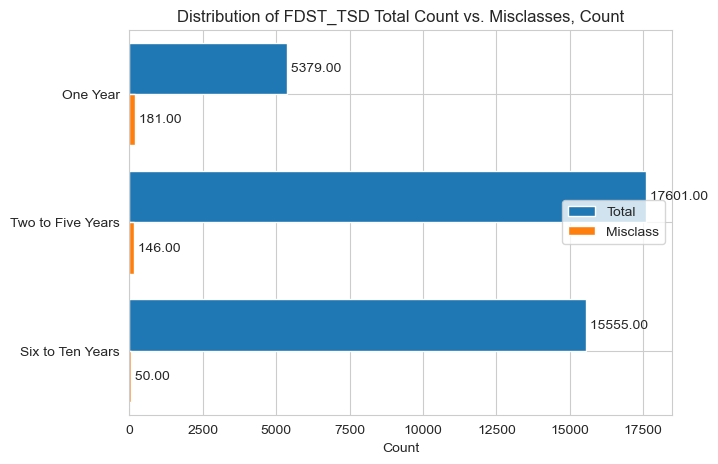

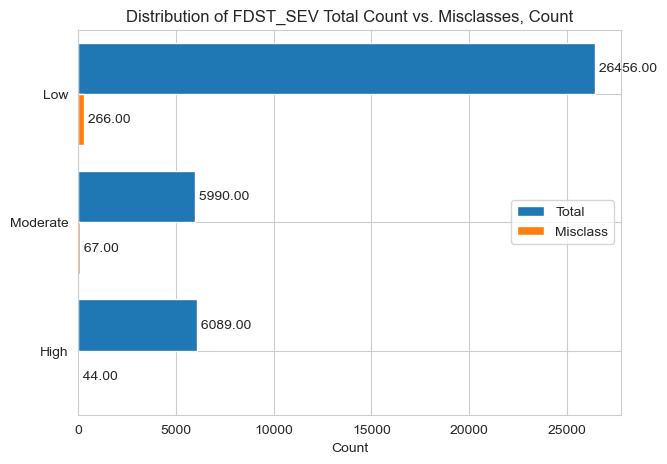

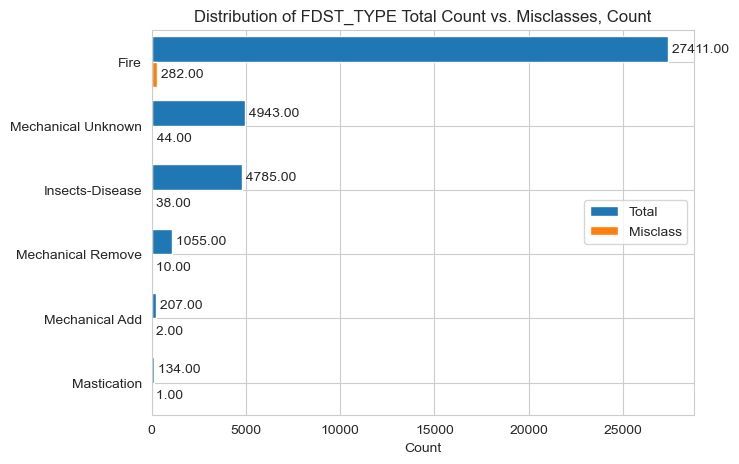

In [61]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVH'] == predictions['Predicted_LF22_FVH'])]

# Drop FDST_TYPE groups not in misclass
mis_type_gps = misclass['FDST_TYPE'].unique()
preds_dropped = predictions.loc[predictions['FDST_TYPE'].isin(mis_type_gps)]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Count'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_comparison_distribution(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))

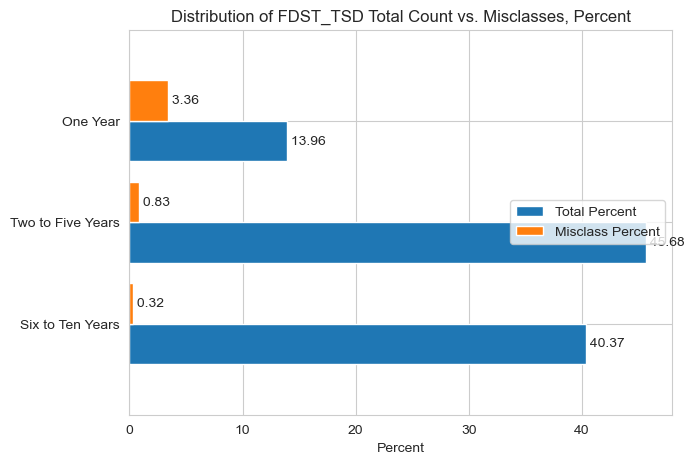

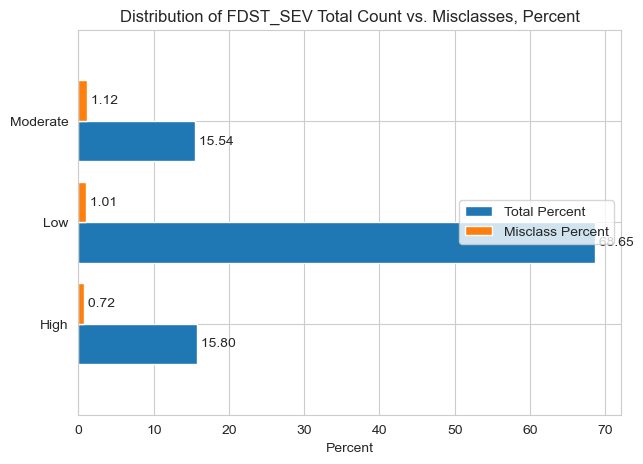

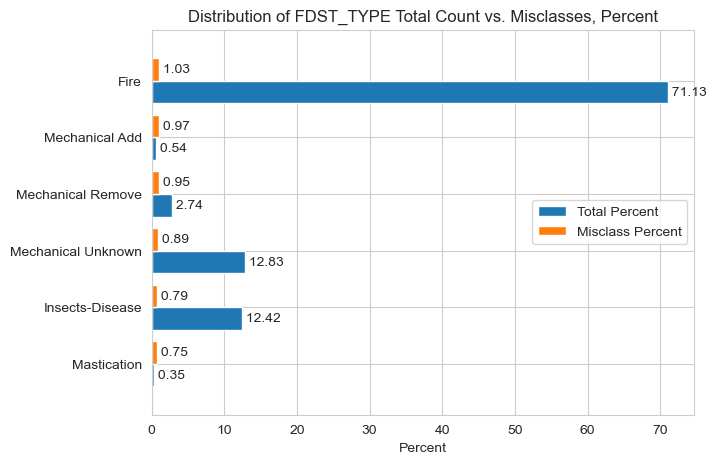

In [62]:
# Get misclasses
misclass = predictions.loc[~(predictions['LF22_FVH'] == predictions['Predicted_LF22_FVH'])]

# Drop FDST_TYPE groups not in misclass
mis_type_gps = misclass['FDST_TYPE'].unique()
preds_dropped = predictions.loc[predictions['FDST_TYPE'].isin(mis_type_gps)]

# Define what plots to generate
group_vars = ['FDST_TSD' ,'FDST_SEV', 'FDST_TYPE']

# Generate plots
metric = 'Percent'
df_dict = {'total' : preds_dropped,
           'misclass' : misclass}

for group_var in group_vars:
    title = f'Distribution of {group_var} Total Count vs. Misclasses, {metric}'
    plot_percent_total(df_dict=df_dict, group_var=group_var, metric=metric, title=title, figsize=(7, 5))